# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [29]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [30]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [31]:
# we are forming a dataset with 100000 points
filtered_data=filtered_data.sample(n=100000, random_state=1)

In [32]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [33]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [34]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [35]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [36]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [37]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [38]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(86847, 10)

In [39]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.847

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [40]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [41]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [42]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(86846, 10)


1    73352
0    13494
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [43]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!
I paid way more for this than the current sale price at my local pet store ($26).  My bull terrier puppy had surgery yesterday and we were struggling to find something to turn his attention away from the stitches.  I put treats through the other side and only put one of the treat balls on the one end, saving the second for later.  He did manage to finally dislodge the treat, but even eating that took longer than his Booda Bimples.  So overall I'm very happy.  After he finished the treat on the outside, he had to find a way to get the other treats on the inside.  He's a 50# bull terrier

In [44]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &amp;  2.  The tradition lives on!


In [45]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books & songs when I did my  student teaching for preschoolers & turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children 5 &  2.  The tradition lives on!
I paid way more for this than the current sale price at my local pet store ($26).  My bull terrier puppy had surgery yesterday and we were struggling to find something to turn his attention away from the stitches.  I put treats through the other side and only put one of the treat balls on the one end, saving the second for later.  He did manage to finally dislodge the treat, but even eating that took longer than his Booda Bimples.  So overall I'm very happy.  After he finished the treat on the outside, he had to find a way to get the other treats on the inside.  He's a 50# bull terrier puppy, and 

In [46]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [47]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Received this as a holiday gift, if you are in love with rum you should like this cake. It is nice and moist and has a pungent aroma of rum. It is made in the Cayman Islands. My dog was at first, slightly repelled by the smell but now it is following me around!


In [48]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I can remember seeing the show when it aired on television years ago, when I was a child.  My sister later bought me the LP (which I have to this day,  I'm thirty something).I used this series of books &amp; songs when I did my  student teaching for preschoolers &amp; turned the whole school on to it.  I am now purchasing it on CD, along with the books for my children  &amp;    The tradition lives on!


In [49]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Received this as a holiday gift if you are in love with rum you should like this cake It is nice and moist and has a pungent aroma of rum It is made in the Cayman Islands My dog was at first slightly repelled by the smell but now it is following me around 


In [50]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [51]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████| 86846/86846 [01:59<00:00, 724.84it/s]


In [52]:
preprocessed_reviews[1500]

'received holiday gift love rum like cake nice moist pungent aroma rum made cayman islands dog first slightly repelled smell following around'

In [57]:
type(preprocessed_reviews)

list

In [53]:
final['Cleaned Text']=preprocessed_reviews

In [ ]:
len(preprocessed_reviews)

In [54]:
final_data_for_agg_db = final.sample(n=2000,replace=True)

In [58]:
data_agg=final_data_for_agg_db ['Cleaned Text']
data_agg_check=data_agg.tolist()

In [59]:
score=final['Score'].values

# [4] Featurization

## [4.1] BAG OF WORDS

In [60]:
count_vect = CountVectorizer() 
bag_counts = count_vect.fit_transform(preprocessed_reviews)
#testvalues=count_vect.transform(X_test)
#cvvalues=count_vect.transform(X_cv)

## [4.3] TF-IDF

In [61]:
tf_idf_vect = TfidfVectorizer()
tfidf_text = tf_idf_vect.fit_transform(preprocessed_reviews)


## [4.4] Word2Vec

In [62]:
# Train your own Word2Vec model using your own text corpus for kmeans
i=0
list_of_sentance=[]

for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())



In [63]:
# Train your own Word2Vec model using your own text corpus for Dbscan and agglomerative
i=0
list_of_sentance_aandd=[]

for sentance in data_agg:
    list_of_sentance_aandd.append(sentance.split())



In [64]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8340513110160828), ('awesome', 0.8305466175079346), ('excellent', 0.8304964303970337), ('good', 0.8279229402542114), ('wonderful', 0.7937837839126587), ('perfect', 0.7680556774139404), ('terrific', 0.7661983966827393), ('amazing', 0.7244263887405396), ('nice', 0.7004743814468384), ('decent', 0.6913770437240601)]
[('greatest', 0.7665554285049438), ('best', 0.7136868238449097), ('nastiest', 0.6871300339698792), ('tastiest', 0.6749586462974548), ('disgusting', 0.6727525591850281), ('terrible', 0.6369004249572754), ('awful', 0.6260908842086792), ('smoothest', 0.6158701181411743), ('horrible', 0.6122881174087524), ('closest', 0.5936715602874756)]


In [65]:
#for aggmlomerative and dbscan
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_aandd=Word2Vec(list_of_sentance_aandd,min_count=5,size=50, workers=4)
    print(w2v_model_aandd.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_aandd.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model_aandd=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model_aandd.wv.most_similar('great'))
        print(w2v_model_aandd.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('almost', 0.999812126159668), ('makes', 0.9997992515563965), ('no', 0.9997928738594055), ('way', 0.9997926950454712), ('seems', 0.9997896552085876), ('also', 0.9997869729995728), ('best', 0.9997841119766235), ('juice', 0.9997833967208862), ('less', 0.9997806549072266), ('product', 0.9997798204421997)]
[('fast', 0.9993658065795898), ('next', 0.9993250370025635), ('two', 0.999302864074707), ('organic', 0.9992963075637817), ('problem', 0.9992932677268982), ('cooking', 0.9992872476577759), ('oz', 0.9992870092391968), ('new', 0.9992853403091431), ('healthy', 0.9992842078208923), ('full', 0.9992824196815491)]


In [66]:
w2v_words_aandd = list(w2v_model_aandd.wv.vocab) #for dbscan and agglomerative
print("number of words that occured minimum 5 times ",len(w2v_words_aandd))
print("sample words ", w2v_words_aandd[0:50])

number of words that occured minimum 5 times  2489
sample words  ['love', 'coffee', 'strong', 'not', 'bitter', 'full', 'bodied', 'tastes', 'excellent', 'tried', 'many', 'keurig', 'coffees', 'one', 'among', 'best', 'nice', 'mix', 'really', 'fact', 'ordered', 'night', 'got', 'afternoon', 'anyone', 'else', 'seasonal', 'type', 'stuff', 'allergies', 'bottle', 'little', 'test', 'taking', 'twice', 'day', 'thought', 'caught', 'cold', 'developed', 'bad', 'get', 'truly', 'awful', 'wanted', 'go', 'home', 'early', 'feeling', 'sick']


In [70]:
w2v_words = list(w2v_model.wv.vocab) ##for linear kmeans
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17716
sample words  ['remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'student', 'teaching', 'preschoolers', 'turned', 'whole', 'school', 'purchasing', 'cd', 'along', 'children', 'tradition', 'lives', 'twist', 'captured', 'film', 'starring', 'michael', 'keaton', 'geena', 'davis', 'prime', 'tim', 'burton', 'masterpiece', 'wonderfully', 'paced', 'point', 'not', 'dull', 'moment', 'one', 'movie', 'collection', 'filled']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [71]:
# average Word2Vec for kmeans

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████| 86846/86846 [17:00<00:00, 85.14it/s]


86846
50


In [72]:
# average Word2Vec for agglomearive and dbscan

sent_vectors_aandd = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_aandd): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_aandd:
            vec = w2v_model_aandd.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_aandd.append(sent_vec)
print(len(sent_vectors_aandd))
print(len(sent_vectors_aandd[0]))

100%|█████████████████████████████████████| 2000/2000 [00:05<00:00, 382.56it/s]


2000
50


#### [4.4.1.2] TFIDF weighted W2v

In [77]:
# Tfidf word to vec model training for kmeans
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [78]:
# Tfidf word to vec model training for dbscan and agglomerative
model_aandd = TfidfVectorizer()
tf_idf_matrix_aandd = model_aandd.fit_transform(data_agg)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_aandd = dict(zip(model_aandd.get_feature_names(), list(model_aandd.idf_)))

In [80]:
# TF-IDF weighted Word2Vec training for kmeans
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    


  0%|                                   | 112/86846 [00:44<15:24:46,  1.56it/s]


  0%|                                   | 224/86846 [01:32<13:00:09,  1.85it/s]


  0%|▏                                   | 338/86846 [02:12<8:29:40,  2.83it/s]


  1%|▏                                   | 453/86846 [02:45<4:23:58,  5.45it/s]


  1%|▏                                   | 567/86846 [03:24<7:05:03,  3.38it/s]


  1%|▎                                   | 687/86846 [03:59<7:21:03,  3.26it/s]


  1%|▎                                   | 805/86846 [04:36<5:09:13,  4.64it/s]


  1%|▍                                   | 918/86846 [05:39<7:18:32,  3.27it/s]


  1%|▍                                 | 1030/86846 [06:17<13:49:11,  1.72it/s]


  1%|▍                                  | 1155/86846 [06:43<4:46:15,  4.99it/s]


  1%|▌                                  | 1270/86846 [07:18<6:58:02,  3.41it/s]


  2%|▌                                  | 1380/86846 [07:49<6:55:38,  3.43it/s]


  2%|▌                                  | 1509/86846 [08:13<4:44:12,  5.00it/s]


  2%|▋                                  | 1632/86846 [08:37<4:00:36,  5.90it/s]


  2%|▋                                  | 1764/86846 [09:04<4:06:03,  5.76it/s]


  2%|▊                                  | 1889/86846 [09:35<3:46:07,  6.26it/s]


  2%|▊                                  | 2010/86846 [10:03<4:20:43,  5.42it/s]


  2%|▊                                 | 2124/86846 [10:38<10:16:49,  2.29it/s]


  3%|▉                                  | 2255/86846 [11:06<4:48:19,  4.89it/s]


  3%|▉                                  | 2384/86846 [11:33<4:39:40,  5.03it/s]


  3%|█                                  | 2522/86846 [12:01<4:54:09,  4.78it/s]


  3%|█                                  | 2656/86846 [12:25<3:43:04,  6.29it/s]


  3%|█▏                                 | 2826/86846 [12:49<2:39:25,  8.78it/s]


  3%|█▏                                 | 2967/86846 [13:12<4:07:07,  5.66it/s]


  4%|█▎                                 | 3123/86846 [13:38<4:58:19,  4.68it/s]


  4%|█▎                                 | 3256/86846 [14:04<3:29:58,  6.64it/s]


  4%|█▍                                 | 3412/86846 [14:28<3:40:27,  6.31it/s]


  4%|█▍                                 | 3551/86846 [14:53<3:00:34,  7.69it/s]


  4%|█▍                                 | 3697/86846 [15:17<5:57:06,  3.88it/s]


  4%|█▌                                 | 3830/86846 [15:41<4:49:34,  4.78it/s]


  5%|█▌                                 | 3972/86846 [16:05<3:12:37,  7.17it/s]


  5%|█▋                                 | 4102/86846 [16:31<5:12:37,  4.41it/s]


  5%|█▋                                 | 4247/86846 [16:55<3:01:15,  7.59it/s]


  5%|█▊                                 | 4387/86846 [17:17<3:14:24,  7.07it/s]


  5%|█▊                                 | 4531/86846 [17:41<2:57:56,  7.71it/s]


  5%|█▉                                 | 4672/86846 [18:02<2:50:24,  8.04it/s]


  6%|█▉                                 | 4850/86846 [18:25<4:26:07,  5.14it/s]


  6%|██                                 | 4994/86846 [18:49<3:11:36,  7.12it/s]


  6%|██                                 | 5150/86846 [19:13<7:49:14,  2.90it/s]


  6%|██▏                                | 5294/86846 [19:38<3:51:16,  5.88it/s]


  6%|██▏                                | 5453/86846 [20:00<3:17:43,  6.86it/s]


  6%|██▎                                | 5586/86846 [20:23<5:34:16,  4.05it/s]


  7%|██▎                                | 5733/86846 [20:45<3:40:16,  6.14it/s]


  7%|██▎                                | 5881/86846 [21:08<3:39:57,  6.13it/s]


  7%|██▍                                | 6029/86846 [21:32<3:47:42,  5.92it/s]


  7%|██▍                                | 6178/86846 [21:55<3:38:12,  6.16it/s]


  7%|██▌                                | 6315/86846 [22:18<5:24:08,  4.14it/s]


  7%|██▌                                | 6453/86846 [22:48<6:09:37,  3.63it/s]


  8%|██▋                                | 6575/86846 [23:18<4:41:18,  4.76it/s]


  8%|██▋                                | 6697/86846 [23:52<5:56:25,  3.75it/s]


  8%|██▋                                | 6818/86846 [24:32<8:55:58,  2.49it/s]


  8%|██▊                                | 6931/86846 [25:09<3:35:02,  6.19it/s]


  8%|██▊                                | 7059/86846 [25:38<5:29:36,  4.03it/s]


  8%|██▉                                | 7192/86846 [26:07<6:51:17,  3.23it/s]


  8%|██▉                                | 7322/86846 [26:35<3:29:38,  6.32it/s]


  9%|███                                | 7455/86846 [27:01<5:52:31,  3.75it/s]


  9%|███                                | 7589/86846 [27:28<3:50:49,  5.72it/s]


  9%|███                                | 7725/86846 [27:52<6:17:38,  3.49it/s]


  9%|███▏                               | 7859/86846 [28:16<2:45:05,  7.97it/s]


  9%|███▏                               | 7985/86846 [28:42<3:53:16,  5.63it/s]


  9%|███▎                               | 8107/86846 [29:10<4:01:55,  5.42it/s]


  9%|███▎                               | 8242/86846 [29:37<5:22:12,  4.07it/s]


 10%|███▍                               | 8380/86846 [30:05<3:49:58,  5.69it/s]


 10%|███▍                               | 8528/86846 [30:34<4:49:30,  4.51it/s]


 10%|███▍                               | 8663/86846 [31:02<3:59:37,  5.44it/s]


 10%|███▌                               | 8799/86846 [31:27<6:14:18,  3.48it/s]


 10%|███▌                               | 8925/86846 [31:58<6:59:47,  3.09it/s]


 10%|███▋                               | 9037/86846 [32:33<4:13:44,  5.11it/s]


 11%|███▋                               | 9149/86846 [33:03<5:52:03,  3.68it/s]


 11%|███▋                              | 9273/86846 [33:34<16:37:07,  1.30it/s]


 11%|███▊                               | 9389/86846 [34:07<8:24:00,  2.56it/s]


 11%|███▋                              | 9509/86846 [34:49<13:24:15,  1.60it/s]


 11%|███▉                               | 9622/86846 [35:34<6:22:16,  3.37it/s]


 11%|███▉                               | 9750/86846 [36:01<3:32:37,  6.04it/s]


 11%|███▉                               | 9888/86846 [36:32<6:19:55,  3.38it/s]


 12%|███▉                              | 10016/86846 [37:03<5:32:36,  3.85it/s]


 12%|███▉                              | 10138/86846 [37:35<6:16:11,  3.40it/s]


 12%|████                              | 10284/86846 [37:59<3:34:40,  5.94it/s]


 12%|████                              | 10420/86846 [38:24<5:18:33,  4.00it/s]


 12%|████▏                             | 10555/86846 [38:54<3:25:51,  6.18it/s]


 12%|████▏                             | 10686/86846 [39:25<5:50:44,  3.62it/s]


 12%|████▏                             | 10822/86846 [39:55<4:57:48,  4.25it/s]


 13%|████▎                             | 10959/86846 [40:21<4:44:45,  4.44it/s]


 13%|████▎                             | 11085/86846 [40:56<3:51:34,  5.45it/s]


 13%|████▍                             | 11208/86846 [41:28<3:38:33,  5.77it/s]


 13%|████▍                             | 11338/86846 [41:58<2:31:00,  8.33it/s]


 13%|████▍                             | 11467/86846 [42:23<5:19:36,  3.93it/s]


 13%|████▌                             | 11608/86846 [42:52<5:04:58,  4.11it/s]


 14%|████▍                            | 11738/86846 [43:22<10:02:20,  2.08it/s]


 14%|████▋                             | 11866/86846 [43:55<4:15:26,  4.89it/s]


 14%|████▋                             | 11990/86846 [44:20<4:10:29,  4.98it/s]


 14%|████▋                             | 12131/86846 [44:46<3:29:09,  5.95it/s]


 14%|████▊                             | 12276/86846 [45:11<2:13:12,  9.33it/s]


 14%|████▊                             | 12445/86846 [45:38<6:04:08,  3.41it/s]


 14%|████▉                             | 12588/86846 [46:04<3:29:09,  5.92it/s]


 15%|████▉                             | 12736/86846 [46:29<3:56:56,  5.21it/s]


 15%|█████                             | 12864/86846 [46:57<3:56:05,  5.22it/s]


 15%|█████                             | 13017/86846 [47:21<3:33:29,  5.76it/s]


 15%|█████▏                            | 13155/86846 [47:48<4:38:27,  4.41it/s]


 15%|█████▏                            | 13297/86846 [48:15<4:29:53,  4.54it/s]


 15%|█████▎                            | 13427/86846 [48:43<2:44:48,  7.42it/s]


 16%|█████▎                            | 13594/86846 [49:10<3:18:31,  6.15it/s]


 16%|█████▍                            | 13740/86846 [49:36<5:24:15,  3.76it/s]


 16%|█████▍                            | 13889/86846 [50:08<5:22:10,  3.77it/s]


 16%|█████▍                            | 14012/86846 [50:39<5:58:01,  3.39it/s]


 16%|█████▍                           | 14155/86846 [51:05<10:09:19,  1.99it/s]


 16%|█████▌                            | 14286/86846 [51:28<6:09:14,  3.28it/s]


 17%|█████▋                            | 14448/86846 [51:52<2:40:18,  7.53it/s]


 17%|█████▋                            | 14568/86846 [52:25<4:11:27,  4.79it/s]


 17%|█████▋                            | 14686/86846 [52:56<5:28:54,  3.66it/s]


 17%|█████▊                            | 14826/86846 [53:22<3:28:49,  5.75it/s]


 17%|█████▊                            | 14965/86846 [53:48<3:20:02,  5.99it/s]


 17%|█████▉                            | 15107/86846 [54:14<6:31:22,  3.05it/s]


 18%|█████▉                            | 15248/86846 [54:40<3:20:16,  5.96it/s]


 18%|██████                            | 15369/86846 [55:10<8:45:59,  2.26it/s]


 18%|██████                            | 15493/86846 [55:43<4:36:47,  4.30it/s]


 18%|██████▏                           | 15676/86846 [56:05<2:29:02,  7.96it/s]


 18%|██████▏                           | 15824/86846 [56:42<4:33:07,  4.33it/s]


 18%|██████▏                           | 15956/86846 [57:09<3:42:24,  5.31it/s]


 19%|██████▎                           | 16106/86846 [57:35<3:13:17,  6.10it/s]


 19%|██████▎                           | 16237/86846 [58:03<5:47:26,  3.39it/s]


 19%|██████▍                           | 16382/86846 [58:28<2:46:45,  7.04it/s]


 19%|██████▎                          | 16515/86846 [58:59<11:53:57,  1.64it/s]


 19%|██████▌                           | 16663/86846 [59:24<2:04:37,  9.39it/s]


 19%|██████▌                           | 16819/86846 [59:49<3:01:28,  6.43it/s]


 20%|██████▎                         | 16968/86846 [1:00:15<2:36:46,  7.43it/s]


 20%|██████▎                         | 17105/86846 [1:00:38<3:23:44,  5.71it/s]


 20%|██████▎                         | 17239/86846 [1:01:01<4:56:20,  3.91it/s]


 20%|██████▍                         | 17371/86846 [1:01:24<3:55:54,  4.91it/s]


 20%|██████▍                         | 17501/86846 [1:01:51<4:21:42,  4.42it/s]


 20%|██████▍                         | 17632/86846 [1:02:18<4:53:00,  3.94it/s]


 20%|██████▌                         | 17780/86846 [1:02:41<3:20:13,  5.75it/s]


 21%|██████▌                         | 17914/86846 [1:03:08<4:57:21,  3.86it/s]


 21%|██████▋                         | 18058/86846 [1:03:34<4:56:42,  3.86it/s]


 21%|██████▋                         | 18170/86846 [1:04:17<3:39:47,  5.21it/s]


 21%|██████▋                         | 18300/86846 [1:04:50<8:14:49,  2.31it/s]


 21%|██████▊                         | 18405/86846 [1:05:29<6:57:35,  2.73it/s]


 21%|██████▊                         | 18521/86846 [1:06:08<3:56:39,  4.81it/s]


 21%|██████▊                         | 18645/86846 [1:06:43<4:26:04,  4.27it/s]


 22%|██████▉                         | 18771/86846 [1:07:20<4:01:22,  4.70it/s]


 22%|██████▋                        | 18897/86846 [1:07:59<11:47:45,  1.60it/s]


 22%|███████                         | 19031/86846 [1:08:32<2:47:51,  6.73it/s]


 22%|███████                         | 19148/86846 [1:09:04<3:40:53,  5.11it/s]


 22%|███████                         | 19278/86846 [1:09:45<3:15:30,  5.76it/s]


 22%|███████▏                        | 19399/86846 [1:10:17<3:35:49,  5.21it/s]


 22%|███████▏                        | 19530/86846 [1:10:44<3:17:33,  5.68it/s]


 23%|███████▏                        | 19646/86846 [1:11:14<3:52:36,  4.81it/s]


 23%|███████▎                        | 19757/86846 [1:11:53<5:58:30,  3.12it/s]


 23%|███████▎                        | 19874/86846 [1:12:31<6:29:49,  2.86it/s]


 23%|███████▎                        | 19996/86846 [1:13:09<4:11:33,  4.43it/s]


 23%|███████▍                        | 20119/86846 [1:13:45<7:49:55,  2.37it/s]


 23%|███████▏                       | 20238/86846 [1:14:30<11:51:03,  1.56it/s]


 23%|███████▌                        | 20359/86846 [1:15:02<4:41:37,  3.93it/s]


 24%|███████▌                        | 20479/86846 [1:15:37<5:54:06,  3.12it/s]


 24%|███████▌                        | 20599/86846 [1:16:18<7:06:27,  2.59it/s]


 24%|███████▋                        | 20724/86846 [1:16:45<3:00:01,  6.12it/s]


 24%|███████▋                        | 20843/86846 [1:17:21<4:39:44,  3.93it/s]


 24%|███████▋                        | 20960/86846 [1:18:01<5:48:43,  3.15it/s]


 24%|███████▊                        | 21075/86846 [1:18:42<4:28:10,  4.09it/s]


 24%|███████▊                        | 21195/86846 [1:19:22<3:41:58,  4.93it/s]


 25%|███████▊                        | 21310/86846 [1:20:04<4:29:27,  4.05it/s]


 25%|███████▉                        | 21433/86846 [1:20:47<3:32:14,  5.14it/s]


 25%|███████▋                       | 21560/86846 [1:21:29<12:09:46,  1.49it/s]


 25%|███████▉                        | 21682/86846 [1:22:02<4:17:16,  4.22it/s]


 25%|████████                        | 21809/86846 [1:22:33<4:39:05,  3.88it/s]


 25%|████████                        | 21930/86846 [1:23:13<3:50:33,  4.69it/s]


 25%|████████                        | 22046/86846 [1:23:51<3:57:23,  4.55it/s]


 26%|████████▏                       | 22171/86846 [1:24:23<4:29:27,  4.00it/s]


 26%|████████▏                       | 22290/86846 [1:24:51<3:11:54,  5.61it/s]


 26%|████████▎                       | 22410/86846 [1:25:27<6:19:34,  2.83it/s]


 26%|████████▎                       | 22524/86846 [1:25:57<5:04:11,  3.52it/s]


 26%|████████                       | 22645/86846 [1:26:35<11:19:30,  1.57it/s]


 26%|████████▍                       | 22767/86846 [1:27:09<7:27:21,  2.39it/s]


 26%|████████▍                       | 22883/86846 [1:27:40<6:18:08,  2.82it/s]


 26%|████████▍                       | 23003/86846 [1:28:11<5:19:16,  3.33it/s]


 27%|████████▌                       | 23131/86846 [1:28:42<6:43:28,  2.63it/s]


 27%|████████▌                       | 23243/86846 [1:29:18<4:03:49,  4.35it/s]


 27%|████████▌                       | 23363/86846 [1:29:58<7:47:16,  2.26it/s]


 27%|████████▋                       | 23475/86846 [1:30:34<6:37:32,  2.66it/s]


 27%|████████▋                       | 23588/86846 [1:31:13<4:04:04,  4.32it/s]


 27%|████████▋                       | 23701/86846 [1:31:45<3:44:58,  4.68it/s]


 27%|████████▊                       | 23814/86846 [1:32:16<6:57:37,  2.52it/s]


 28%|████████▊                       | 23932/86846 [1:32:46<4:27:45,  3.92it/s]


 28%|████████▊                       | 24049/86846 [1:33:25<6:52:58,  2.53it/s]


 28%|████████▉                       | 24166/86846 [1:34:08<5:19:19,  3.27it/s]


 28%|████████▉                       | 24276/86846 [1:34:49<4:02:54,  4.29it/s]


 28%|████████▉                       | 24392/86846 [1:35:21<5:29:17,  3.16it/s]


 28%|█████████                       | 24508/86846 [1:35:53<7:26:24,  2.33it/s]


 28%|█████████                       | 24624/86846 [1:36:23<3:13:23,  5.36it/s]


 28%|█████████                       | 24738/86846 [1:37:02<4:55:15,  3.51it/s]


 29%|█████████▏                      | 24843/86846 [1:37:39<5:44:38,  3.00it/s]


 29%|█████████▏                      | 24953/86846 [1:38:17<3:02:06,  5.66it/s]


 29%|████████▉                      | 25064/86846 [1:39:03<10:42:15,  1.60it/s]


 29%|█████████▎                      | 25186/86846 [1:39:41<3:09:15,  5.43it/s]


 29%|█████████▎                      | 25303/86846 [1:40:16<7:37:57,  2.24it/s]


 29%|█████████▎                      | 25424/86846 [1:40:49<3:36:48,  4.72it/s]


 29%|█████████▍                      | 25546/86846 [1:41:22<7:26:30,  2.29it/s]


 30%|█████████▍                      | 25660/86846 [1:42:11<3:36:57,  4.70it/s]


 30%|█████████▍                      | 25781/86846 [1:42:41<5:54:02,  2.87it/s]


 30%|█████████▌                      | 25899/86846 [1:43:12<5:23:01,  3.14it/s]


 30%|█████████▌                      | 26017/86846 [1:43:42<4:27:45,  3.79it/s]


 30%|█████████▋                      | 26133/86846 [1:44:13<5:17:14,  3.19it/s]


 30%|█████████▋                      | 26243/86846 [1:44:50<6:02:16,  2.79it/s]


 30%|█████████▋                      | 26358/86846 [1:45:24<5:08:25,  3.27it/s]


 30%|█████████▊                      | 26474/86846 [1:45:58<4:23:29,  3.82it/s]


 31%|█████████▊                      | 26592/86846 [1:46:32<5:00:07,  3.35it/s]


 31%|█████████▊                      | 26710/86846 [1:47:01<4:35:14,  3.64it/s]


 31%|█████████▉                      | 26830/86846 [1:47:34<4:47:17,  3.48it/s]


 31%|█████████▉                      | 26953/86846 [1:48:10<4:31:31,  3.68it/s]


 31%|█████████▉                      | 27078/86846 [1:48:44<4:48:30,  3.45it/s]


 31%|██████████                      | 27208/86846 [1:49:24<4:47:59,  3.45it/s]


 31%|██████████                      | 27333/86846 [1:49:54<4:04:30,  4.06it/s]


 32%|██████████                      | 27452/86846 [1:50:24<7:33:30,  2.18it/s]


 32%|██████████▏                     | 27579/86846 [1:51:01<6:18:53,  2.61it/s]


 32%|██████████▏                     | 27684/86846 [1:51:51<5:51:18,  2.81it/s]


 32%|██████████▏                     | 27799/86846 [1:52:30<6:13:19,  2.64it/s]


 32%|██████████▎                     | 27910/86846 [1:53:12<6:27:39,  2.53it/s]


 32%|██████████▎                     | 28025/86846 [1:53:58<4:38:25,  3.52it/s]


 32%|██████████▎                     | 28135/86846 [1:54:36<3:23:06,  4.82it/s]


 33%|██████████▍                     | 28248/86846 [1:55:25<5:28:03,  2.98it/s]


 33%|██████████▍                     | 28364/86846 [1:56:01<5:35:00,  2.91it/s]


 33%|██████████▍                     | 28474/86846 [1:56:36<8:12:09,  1.98it/s]


 33%|██████████▌                     | 28589/86846 [1:57:14<5:37:32,  2.88it/s]


 33%|██████████▌                     | 28700/86846 [1:57:46<3:29:32,  4.62it/s]


 33%|██████████▌                     | 28809/86846 [1:58:22<5:08:51,  3.13it/s]


 33%|██████████▋                     | 28921/86846 [1:58:53<5:19:26,  3.02it/s]


 33%|██████████▋                     | 29034/86846 [1:59:26<4:26:06,  3.62it/s]


 34%|██████████▋                     | 29144/86846 [1:59:59<7:56:11,  2.02it/s]


 34%|██████████▊                     | 29251/86846 [2:00:31<6:41:57,  2.39it/s]


 34%|██████████▊                     | 29360/86846 [2:01:04<3:25:51,  4.65it/s]


 34%|██████████▊                     | 29469/86846 [2:01:43<4:16:39,  3.73it/s]


 34%|██████████▉                     | 29573/86846 [2:02:20<6:09:40,  2.58it/s]


 34%|██████████▉                     | 29680/86846 [2:02:56<4:57:42,  3.20it/s]


 34%|██████████▋                    | 29786/86846 [2:03:35<13:57:25,  1.14it/s]


 34%|███████████                     | 29891/86846 [2:04:13<9:23:46,  1.68it/s]


 35%|███████████                     | 30003/86846 [2:04:51<5:43:07,  2.76it/s]


 35%|███████████                     | 30114/86846 [2:05:25<7:14:33,  2.18it/s]


 35%|███████████▏                    | 30220/86846 [2:06:00<5:13:38,  3.01it/s]


 35%|███████████▏                    | 30327/86846 [2:06:36<4:40:57,  3.35it/s]


 35%|███████████▏                    | 30438/86846 [2:07:13<7:10:34,  2.18it/s]


 35%|███████████▎                    | 30544/86846 [2:07:47<3:36:19,  4.34it/s]


 35%|███████████▎                    | 30649/86846 [2:08:19<3:09:46,  4.94it/s]


 35%|███████████▎                    | 30757/86846 [2:08:53<5:32:05,  2.81it/s]


 36%|███████████▎                    | 30866/86846 [2:09:29<6:41:26,  2.32it/s]


 36%|███████████▍                    | 30975/86846 [2:10:06<5:24:20,  2.87it/s]


 36%|███████████▍                    | 31085/86846 [2:10:40<6:07:33,  2.53it/s]


 36%|███████████▍                    | 31198/86846 [2:11:10<7:25:04,  2.08it/s]


 36%|███████████▌                    | 31302/86846 [2:11:40<3:45:14,  4.11it/s]


 36%|███████████▌                    | 31413/86846 [2:12:14<2:32:54,  6.04it/s]


 36%|███████████▌                    | 31522/86846 [2:12:49<5:11:44,  2.96it/s]


 36%|███████████▋                    | 31629/86846 [2:13:23<9:30:06,  1.61it/s]


 37%|███████████▋                    | 31733/86846 [2:13:56<3:46:06,  4.06it/s]


 37%|███████████▋                    | 31844/86846 [2:14:29<4:55:12,  3.11it/s]


 37%|███████████▊                    | 31950/86846 [2:15:02<3:47:28,  4.02it/s]


 37%|███████████▊                    | 32061/86846 [2:15:34<3:41:13,  4.13it/s]


 37%|███████████▊                    | 32172/86846 [2:16:06<4:33:35,  3.33it/s]


 37%|███████████▉                    | 32277/86846 [2:16:40<4:43:38,  3.21it/s]


 37%|███████████▉                    | 32387/86846 [2:17:17<7:55:56,  1.91it/s]


 37%|███████████▉                    | 32493/86846 [2:17:55<7:08:53,  2.11it/s]


 38%|████████████                    | 32607/86846 [2:18:27<3:46:28,  3.99it/s]


 38%|████████████                    | 32720/86846 [2:19:02<4:15:09,  3.54it/s]


 38%|████████████                    | 32829/86846 [2:19:40<3:57:12,  3.80it/s]


 38%|████████████▏                   | 32945/86846 [2:20:21<3:16:22,  4.57it/s]


 38%|████████████▏                   | 33060/86846 [2:20:52<4:07:43,  3.62it/s]


 38%|████████████▏                   | 33167/86846 [2:21:19<4:46:55,  3.12it/s]


 38%|████████████▎                   | 33279/86846 [2:21:56<6:40:18,  2.23it/s]


 38%|████████████▎                   | 33390/86846 [2:22:27<3:08:54,  4.72it/s]


 39%|████████████▎                   | 33499/86846 [2:22:55<3:10:28,  4.67it/s]


 39%|████████████▍                   | 33616/86846 [2:23:27<4:48:45,  3.07it/s]


 39%|████████████▍                   | 33726/86846 [2:23:56<3:23:15,  4.36it/s]


 39%|████████████▍                   | 33839/86846 [2:24:24<2:38:37,  5.57it/s]


 39%|████████████▌                   | 33947/86846 [2:24:54<4:42:37,  3.12it/s]


 39%|████████████▌                   | 34059/86846 [2:25:24<3:17:50,  4.45it/s]


 39%|████████████▌                   | 34174/86846 [2:25:53<2:12:36,  6.62it/s]


 39%|████████████▋                   | 34286/86846 [2:26:27<4:19:07,  3.38it/s]


 40%|████████████▋                   | 34398/86846 [2:27:04<4:41:55,  3.10it/s]


 40%|████████████▋                   | 34508/86846 [2:27:35<5:43:12,  2.54it/s]


 40%|████████████▊                   | 34620/86846 [2:28:09<5:52:06,  2.47it/s]


 40%|████████████▊                   | 34728/86846 [2:28:45<6:48:44,  2.13it/s]


 40%|████████████▊                   | 34840/86846 [2:29:17<4:00:43,  3.60it/s]


 40%|████████████▉                   | 34952/86846 [2:29:47<3:38:16,  3.96it/s]


 40%|████████████▉                   | 35067/86846 [2:30:20<5:51:34,  2.45it/s]


 41%|████████████▉                   | 35180/86846 [2:30:51<2:27:04,  5.85it/s]


 41%|█████████████                   | 35290/86846 [2:31:30<3:59:52,  3.58it/s]


 41%|█████████████                   | 35407/86846 [2:32:04<3:56:43,  3.62it/s]


 41%|█████████████                   | 35521/86846 [2:32:33<6:43:20,  2.12it/s]


 41%|█████████████▏                  | 35637/86846 [2:33:05<3:42:54,  3.83it/s]


 41%|█████████████▏                  | 35748/86846 [2:33:37<3:10:47,  4.46it/s]


 41%|█████████████▏                  | 35860/86846 [2:34:11<3:05:51,  4.57it/s]


 41%|█████████████▎                  | 35975/86846 [2:34:43<5:20:38,  2.64it/s]


 42%|█████████████▎                  | 36086/86846 [2:35:15<4:23:47,  3.21it/s]


 42%|█████████████▎                  | 36199/86846 [2:35:51<3:59:01,  3.53it/s]


 42%|█████████████▍                  | 36314/86846 [2:36:25<3:32:31,  3.96it/s]


 42%|█████████████▍                  | 36424/86846 [2:36:55<5:11:15,  2.70it/s]


 42%|█████████████▍                  | 36538/86846 [2:37:26<6:28:25,  2.16it/s]


 42%|█████████████▌                  | 36652/86846 [2:38:05<3:50:55,  3.62it/s]


 42%|█████████████▌                  | 36764/86846 [2:38:33<3:05:17,  4.50it/s]


 42%|█████████████▌                  | 36872/86846 [2:39:03<4:40:21,  2.97it/s]


 43%|█████████████▋                  | 36984/86846 [2:39:35<3:19:57,  4.16it/s]


 43%|█████████████▋                  | 37098/86846 [2:40:08<3:33:54,  3.88it/s]


 43%|█████████████▋                  | 37211/86846 [2:40:42<3:22:19,  4.09it/s]


 43%|█████████████▊                  | 37328/86846 [2:41:13<2:31:37,  5.44it/s]


 43%|█████████████▊                  | 37438/86846 [2:41:42<3:01:29,  4.54it/s]


 43%|█████████████▊                  | 37558/86846 [2:42:10<2:31:08,  5.43it/s]


 43%|█████████████▉                  | 37672/86846 [2:42:38<5:00:41,  2.73it/s]


 44%|█████████████▉                  | 37782/86846 [2:43:12<4:31:57,  3.01it/s]


 44%|█████████████▉                  | 37895/86846 [2:43:38<2:57:55,  4.59it/s]


 44%|██████████████                  | 38008/86846 [2:44:07<3:33:03,  3.82it/s]


 44%|██████████████                  | 38122/86846 [2:44:33<2:14:34,  6.03it/s]


 44%|██████████████                  | 38237/86846 [2:45:04<4:02:37,  3.34it/s]


 44%|██████████████▏                 | 38351/86846 [2:45:35<2:17:46,  5.87it/s]


 44%|██████████████▏                 | 38462/86846 [2:46:10<4:13:34,  3.18it/s]


 44%|██████████████▏                 | 38575/86846 [2:46:44<3:07:09,  4.30it/s]


 45%|██████████████▎                 | 38687/86846 [2:47:15<3:00:07,  4.46it/s]


 45%|██████████████▎                 | 38802/86846 [2:47:46<4:23:51,  3.03it/s]


 45%|██████████████▎                 | 38915/86846 [2:48:15<3:39:47,  3.63it/s]


 45%|██████████████▍                 | 39029/86846 [2:48:49<9:34:22,  1.39it/s]


 45%|██████████████▍                 | 39149/86846 [2:49:25<3:32:57,  3.73it/s]


 45%|██████████████▍                 | 39264/86846 [2:49:53<2:38:04,  5.02it/s]


 45%|██████████████                 | 39378/86846 [2:50:31<13:57:41,  1.06s/it]


 45%|██████████████▌                 | 39497/86846 [2:51:03<3:44:40,  3.51it/s]


 46%|██████████████▌                 | 39610/86846 [2:51:35<3:02:40,  4.31it/s]


 46%|██████████████▋                 | 39725/86846 [2:52:07<2:35:46,  5.04it/s]


 46%|██████████████▋                 | 39839/86846 [2:52:38<4:38:43,  2.81it/s]


 46%|██████████████▋                 | 39951/86846 [2:53:11<4:16:04,  3.05it/s]


 46%|██████████████▊                 | 40068/86846 [2:53:48<4:16:39,  3.04it/s]


 46%|██████████████▊                 | 40177/86846 [2:54:19<3:13:00,  4.03it/s]


 46%|██████████████▊                 | 40292/86846 [2:54:52<3:32:25,  3.65it/s]


 47%|██████████████▉                 | 40404/86846 [2:55:24<2:54:07,  4.45it/s]


 47%|██████████████▉                 | 40515/86846 [2:56:00<4:33:59,  2.82it/s]


 47%|██████████████▉                 | 40625/86846 [2:56:33<3:14:03,  3.97it/s]


 47%|███████████████                 | 40740/86846 [2:57:05<3:16:54,  3.90it/s]


 47%|███████████████                 | 40852/86846 [2:57:39<3:03:01,  4.19it/s]


 47%|███████████████                 | 40965/86846 [2:58:11<3:57:45,  3.22it/s]


 47%|███████████████▏                | 41079/86846 [2:58:42<3:45:41,  3.38it/s]


 47%|███████████████▏                | 41187/86846 [2:59:12<8:49:48,  1.44it/s]


 48%|███████████████▏                | 41302/86846 [2:59:44<2:51:00,  4.44it/s]


 48%|███████████████▎                | 41414/86846 [3:00:15<1:53:39,  6.66it/s]


 48%|███████████████▎                | 41530/86846 [3:00:46<2:45:56,  4.55it/s]


 48%|███████████████▎                | 41640/86846 [3:01:21<6:29:47,  1.93it/s]


 48%|███████████████▍                | 41753/86846 [3:01:56<3:41:47,  3.39it/s]


 48%|███████████████▍                | 41868/86846 [3:02:32<4:54:37,  2.54it/s]


 48%|███████████████▍                | 41981/86846 [3:03:07<3:25:31,  3.64it/s]


 48%|███████████████▌                | 42094/86846 [3:03:40<2:34:22,  4.83it/s]


 49%|███████████████▌                | 42204/86846 [3:04:07<3:42:36,  3.34it/s]


 49%|███████████████▌                | 42320/86846 [3:04:39<2:39:45,  4.64it/s]


 49%|███████████████▋                | 42434/86846 [3:05:11<4:43:09,  2.61it/s]


 49%|███████████████▋                | 42546/86846 [3:05:41<6:50:24,  1.80it/s]


 49%|███████████████▋                | 42660/86846 [3:06:18<2:14:24,  5.48it/s]


 49%|███████████████▊                | 42773/86846 [3:06:50<2:53:46,  4.23it/s]


 49%|███████████████▊                | 42889/86846 [3:07:21<2:38:39,  4.62it/s]


 50%|███████████████▊                | 43000/86846 [3:07:50<3:19:24,  3.66it/s]


 50%|███████████████▉                | 43114/86846 [3:08:22<3:58:47,  3.05it/s]


 50%|███████████████▉                | 43232/86846 [3:08:56<3:25:40,  3.53it/s]


 50%|███████████████▉                | 43345/86846 [3:09:29<2:34:18,  4.70it/s]


 50%|████████████████                | 43466/86846 [3:10:02<4:01:00,  3.00it/s]


 50%|████████████████                | 43575/86846 [3:10:31<3:09:44,  3.80it/s]


 50%|████████████████                | 43690/86846 [3:11:06<5:21:51,  2.23it/s]


 50%|████████████████▏               | 43800/86846 [3:11:45<4:25:10,  2.71it/s]


 51%|████████████████▏               | 43913/86846 [3:12:18<4:54:35,  2.43it/s]


 51%|████████████████▏               | 44025/86846 [3:12:57<3:21:38,  3.54it/s]


 51%|████████████████▎               | 44137/86846 [3:13:28<5:06:38,  2.32it/s]


 51%|████████████████▎               | 44253/86846 [3:14:05<3:40:05,  3.23it/s]


 51%|████████████████▎               | 44363/86846 [3:14:35<2:27:39,  4.80it/s]


 51%|████████████████▍               | 44476/86846 [3:15:08<3:26:44,  3.42it/s]


 51%|████████████████▍               | 44585/86846 [3:15:42<3:02:37,  3.86it/s]


 51%|████████████████▍               | 44692/86846 [3:16:17<2:57:09,  3.97it/s]


 52%|████████████████▌               | 44802/86846 [3:16:47<2:30:02,  4.67it/s]


 52%|████████████████▌               | 44910/86846 [3:17:13<2:48:17,  4.15it/s]


 52%|████████████████▌               | 45026/86846 [3:17:48<3:55:46,  2.96it/s]


 52%|████████████████▋               | 45138/86846 [3:18:21<2:46:23,  4.18it/s]


 52%|████████████████▋               | 45255/86846 [3:18:53<2:43:27,  4.24it/s]


 52%|████████████████▋               | 45367/86846 [3:19:25<3:12:37,  3.59it/s]


 52%|████████████████▊               | 45484/86846 [3:20:00<2:25:47,  4.73it/s]


 53%|████████████████▊               | 45600/86846 [3:20:31<3:23:47,  3.37it/s]


 53%|████████████████▊               | 45710/86846 [3:20:59<2:08:56,  5.32it/s]


 53%|████████████████▉               | 45823/86846 [3:21:31<3:31:31,  3.23it/s]


 53%|████████████████▉               | 45940/86846 [3:22:03<1:59:54,  5.69it/s]


 53%|████████████████▉               | 46053/86846 [3:22:29<2:55:11,  3.88it/s]


 53%|█████████████████               | 46166/86846 [3:22:59<3:34:06,  3.17it/s]


 53%|█████████████████               | 46273/86846 [3:23:30<2:41:45,  4.18it/s]


 53%|█████████████████               | 46388/86846 [3:24:00<5:04:50,  2.21it/s]


 54%|█████████████████▏              | 46500/86846 [3:24:28<3:30:29,  3.19it/s]


 54%|█████████████████▏              | 46621/86846 [3:24:58<3:05:41,  3.61it/s]


 54%|█████████████████▏              | 46733/86846 [3:25:32<3:17:51,  3.38it/s]


 54%|█████████████████▎              | 46848/86846 [3:26:04<2:01:58,  5.47it/s]


 54%|█████████████████▎              | 46964/86846 [3:26:32<2:47:30,  3.97it/s]


 54%|█████████████████▎              | 47079/86846 [3:27:04<4:35:29,  2.41it/s]


 54%|█████████████████▍              | 47194/86846 [3:27:33<2:41:02,  4.10it/s]


 54%|█████████████████▍              | 47307/86846 [3:28:03<2:15:10,  4.88it/s]


 55%|█████████████████▍              | 47421/86846 [3:28:31<2:39:39,  4.12it/s]


 55%|█████████████████▌              | 47538/86846 [3:28:58<1:49:30,  5.98it/s]


 55%|█████████████████▌              | 47652/86846 [3:29:28<3:05:24,  3.52it/s]


 55%|█████████████████▌              | 47764/86846 [3:29:59<2:11:28,  4.95it/s]


 55%|█████████████████▋              | 47887/86846 [3:30:31<4:19:42,  2.50it/s]


 55%|█████████████████▋              | 47998/86846 [3:31:02<1:38:13,  6.59it/s]


 55%|█████████████████▋              | 48116/86846 [3:31:32<3:16:37,  3.28it/s]


 56%|█████████████████▊              | 48230/86846 [3:32:05<4:16:02,  2.51it/s]


 56%|█████████████████▊              | 48342/86846 [3:32:39<2:37:31,  4.07it/s]


 56%|█████████████████▊              | 48456/86846 [3:33:13<3:49:44,  2.79it/s]


 56%|█████████████████▉              | 48573/86846 [3:33:42<3:19:30,  3.20it/s]


 56%|█████████████████▉              | 48686/86846 [3:34:12<2:14:03,  4.74it/s]


 56%|█████████████████▉              | 48796/86846 [3:34:43<2:18:04,  4.59it/s]


 56%|██████████████████              | 48916/86846 [3:35:12<2:11:21,  4.81it/s]


 56%|██████████████████              | 49032/86846 [3:35:44<4:30:08,  2.33it/s]


 57%|██████████████████              | 49152/86846 [3:36:18<3:12:49,  3.26it/s]


 57%|██████████████████▏             | 49262/86846 [3:36:46<3:12:08,  3.26it/s]


 57%|██████████████████▏             | 49377/86846 [3:37:24<2:50:02,  3.67it/s]


 57%|██████████████████▏             | 49493/86846 [3:37:58<2:00:13,  5.18it/s]


 57%|██████████████████▎             | 49604/86846 [3:38:28<4:47:34,  2.16it/s]


 57%|██████████████████▎             | 49720/86846 [3:39:01<2:10:50,  4.73it/s]


 57%|██████████████████▎             | 49830/86846 [3:39:29<3:13:48,  3.18it/s]


 58%|██████████████████▍             | 49946/86846 [3:40:01<2:27:45,  4.16it/s]


 58%|██████████████████▍             | 50065/86846 [3:40:30<2:09:57,  4.72it/s]


 58%|██████████████████▍             | 50179/86846 [3:41:01<3:14:19,  3.14it/s]


 58%|██████████████████▌             | 50294/86846 [3:41:31<1:35:25,  6.38it/s]


 58%|██████████████████▌             | 50405/86846 [3:42:06<3:51:49,  2.62it/s]


 58%|██████████████████▌             | 50520/86846 [3:42:48<3:39:32,  2.76it/s]


 58%|██████████████████▋             | 50633/86846 [3:43:16<2:14:28,  4.49it/s]


 58%|██████████████████▋             | 50745/86846 [3:43:47<5:30:54,  1.82it/s]


 59%|██████████████████▋             | 50856/86846 [3:44:16<2:48:25,  3.56it/s]


 59%|██████████████████▊             | 50966/86846 [3:44:46<3:44:10,  2.67it/s]


 59%|██████████████████▊             | 51078/86846 [3:45:23<2:52:03,  3.46it/s]


 59%|██████████████████▊             | 51191/86846 [3:45:55<1:35:02,  6.25it/s]


 59%|██████████████████▉             | 51305/86846 [3:46:29<2:36:47,  3.78it/s]


 59%|██████████████████▉             | 51417/86846 [3:46:59<2:59:49,  3.28it/s]


 59%|██████████████████▉             | 51527/86846 [3:47:33<3:27:45,  2.83it/s]


 59%|███████████████████             | 51639/86846 [3:48:00<2:16:36,  4.30it/s]


 60%|███████████████████             | 51762/86846 [3:48:34<2:55:08,  3.34it/s]


 60%|███████████████████             | 51876/86846 [3:49:07<2:22:29,  4.09it/s]


 60%|███████████████████▏            | 51996/86846 [3:49:40<4:41:31,  2.06it/s]


 60%|███████████████████▏            | 52107/86846 [3:50:17<1:49:44,  5.28it/s]


 60%|███████████████████▏            | 52218/86846 [3:50:54<2:14:17,  4.30it/s]


 60%|███████████████████▎            | 52327/86846 [3:51:29<2:24:11,  3.99it/s]


 60%|███████████████████▎            | 52437/86846 [3:52:04<3:19:31,  2.87it/s]


 61%|███████████████████▎            | 52548/86846 [3:52:31<1:31:04,  6.28it/s]


 61%|███████████████████▍            | 52657/86846 [3:53:07<2:43:48,  3.48it/s]


 61%|███████████████████▍            | 52768/86846 [3:53:39<3:06:28,  3.05it/s]


 61%|███████████████████▍            | 52887/86846 [3:54:04<1:49:11,  5.18it/s]


 61%|███████████████████▌            | 53003/86846 [3:54:34<2:44:38,  3.43it/s]


 61%|███████████████████▌            | 53118/86846 [3:55:03<1:49:48,  5.12it/s]


 61%|███████████████████▌            | 53243/86846 [3:55:32<4:46:24,  1.96it/s]


 61%|███████████████████▋            | 53357/86846 [3:56:03<3:09:40,  2.94it/s]


 62%|███████████████████▋            | 53471/86846 [3:56:36<1:40:12,  5.55it/s]


 62%|███████████████████▋            | 53579/86846 [3:57:10<2:28:47,  3.73it/s]


 62%|███████████████████▊            | 53691/86846 [3:57:40<1:33:33,  5.91it/s]


 62%|███████████████████▊            | 53806/86846 [3:58:13<4:59:25,  1.84it/s]


 62%|███████████████████▊            | 53923/86846 [3:58:45<2:35:23,  3.53it/s]


 62%|███████████████████▉            | 54039/86846 [3:59:10<1:30:13,  6.06it/s]


 62%|███████████████████▉            | 54160/86846 [3:59:42<2:04:56,  4.36it/s]


 62%|███████████████████▉            | 54278/86846 [4:00:10<3:12:43,  2.82it/s]


 63%|████████████████████            | 54394/86846 [4:00:40<1:52:02,  4.83it/s]


 63%|████████████████████            | 54509/86846 [4:01:11<1:57:28,  4.59it/s]


 63%|████████████████████▏           | 54620/86846 [4:01:44<2:01:37,  4.42it/s]


 63%|████████████████████▏           | 54735/86846 [4:02:13<1:54:30,  4.67it/s]


 63%|████████████████████▏           | 54848/86846 [4:02:43<2:50:56,  3.12it/s]


 63%|████████████████████▎           | 54961/86846 [4:03:25<2:57:10,  3.00it/s]


 63%|████████████████████▎           | 55082/86846 [4:03:55<2:14:53,  3.92it/s]


 64%|████████████████████▎           | 55195/86846 [4:04:23<1:58:11,  4.46it/s]


 64%|████████████████████▍           | 55308/86846 [4:04:52<2:46:28,  3.16it/s]


 64%|████████████████████▍           | 55419/86846 [4:05:23<1:58:29,  4.42it/s]


 64%|████████████████████▍           | 55534/86846 [4:05:52<1:37:19,  5.36it/s]


 64%|████████████████████▌           | 55650/86846 [4:06:24<3:20:50,  2.59it/s]


 64%|████████████████████▌           | 55764/86846 [4:06:52<1:59:33,  4.33it/s]


 64%|████████████████████▌           | 55880/86846 [4:07:20<1:55:43,  4.46it/s]


 64%|████████████████████▋           | 55993/86846 [4:07:47<2:04:38,  4.13it/s]


 65%|████████████████████▋           | 56107/86846 [4:08:18<2:03:57,  4.13it/s]


 65%|████████████████████▋           | 56219/86846 [4:08:48<1:41:39,  5.02it/s]


 65%|████████████████████▊           | 56327/86846 [4:09:15<1:55:07,  4.42it/s]


 65%|████████████████████▊           | 56440/86846 [4:09:42<2:12:34,  3.82it/s]


 65%|████████████████████▊           | 56559/86846 [4:10:12<2:27:33,  3.42it/s]


 65%|████████████████████▉           | 56679/86846 [4:10:38<1:28:59,  5.65it/s]


 65%|████████████████████▉           | 56795/86846 [4:11:08<2:20:49,  3.56it/s]


 66%|████████████████████▉           | 56901/86846 [4:11:42<2:35:14,  3.21it/s]


 66%|█████████████████████           | 57014/86846 [4:12:15<2:35:37,  3.19it/s]


 66%|█████████████████████           | 57129/86846 [4:12:46<2:21:13,  3.51it/s]


 66%|█████████████████████           | 57245/86846 [4:13:12<1:49:59,  4.49it/s]


 66%|█████████████████████▏          | 57360/86846 [4:13:42<2:14:46,  3.65it/s]


 66%|█████████████████████▏          | 57472/86846 [4:14:12<2:28:12,  3.30it/s]


 66%|█████████████████████▏          | 57590/86846 [4:14:44<3:28:41,  2.34it/s]


 66%|█████████████████████▎          | 57705/86846 [4:15:13<2:02:19,  3.97it/s]


 67%|█████████████████████▎          | 57816/86846 [4:15:43<3:25:00,  2.36it/s]


 67%|█████████████████████▎          | 57935/86846 [4:16:13<2:58:47,  2.69it/s]


 67%|█████████████████████▍          | 58045/86846 [4:16:45<2:01:06,  3.96it/s]


 67%|█████████████████████▍          | 58158/86846 [4:17:14<1:34:28,  5.06it/s]


 67%|█████████████████████▍          | 58271/86846 [4:17:44<1:39:51,  4.77it/s]


 67%|█████████████████████▌          | 58386/86846 [4:18:16<2:26:43,  3.23it/s]


 67%|█████████████████████▌          | 58501/86846 [4:18:46<2:01:02,  3.90it/s]


 67%|█████████████████████▌          | 58618/86846 [4:19:18<2:51:57,  2.74it/s]


 68%|█████████████████████▋          | 58731/86846 [4:19:49<2:15:18,  3.46it/s]


 68%|█████████████████████▋          | 58843/86846 [4:20:26<2:48:59,  2.76it/s]


 68%|█████████████████████▋          | 58961/86846 [4:20:58<3:39:07,  2.12it/s]


 68%|█████████████████████▊          | 59075/86846 [4:21:32<1:56:56,  3.96it/s]


 68%|█████████████████████▊          | 59184/86846 [4:22:09<1:53:17,  4.07it/s]


 68%|█████████████████████▊          | 59294/86846 [4:22:44<1:39:26,  4.62it/s]


 68%|█████████████████████▉          | 59405/86846 [4:23:17<2:06:06,  3.63it/s]


 69%|█████████████████████▉          | 59518/86846 [4:23:46<1:41:37,  4.48it/s]


 69%|█████████████████████▉          | 59632/86846 [4:24:20<2:22:59,  3.17it/s]


 69%|██████████████████████          | 59748/86846 [4:24:54<2:33:07,  2.95it/s]


 69%|██████████████████████          | 59863/86846 [4:25:23<1:49:47,  4.10it/s]


 69%|██████████████████████          | 59971/86846 [4:25:53<2:29:10,  3.00it/s]


 69%|██████████████████████▏         | 60080/86846 [4:26:28<3:51:12,  1.93it/s]


 69%|██████████████████████▏         | 60196/86846 [4:27:04<1:28:55,  4.99it/s]


 69%|██████████████████████▏         | 60309/86846 [4:27:36<1:36:38,  4.58it/s]


 70%|██████████████████████▎         | 60426/86846 [4:28:05<2:07:19,  3.46it/s]


 70%|██████████████████████▎         | 60542/86846 [4:28:37<2:14:16,  3.27it/s]


 70%|██████████████████████▎         | 60654/86846 [4:29:12<3:26:02,  2.12it/s]


 70%|██████████████████████▍         | 60767/86846 [4:29:42<1:30:55,  4.78it/s]


 70%|██████████████████████▍         | 60879/86846 [4:30:18<1:55:29,  3.75it/s]


 70%|██████████████████████▍         | 60993/86846 [4:30:52<2:37:44,  2.73it/s]


 70%|██████████████████████▌         | 61107/86846 [4:31:20<2:51:05,  2.51it/s]


 70%|██████████████████████▌         | 61216/86846 [4:31:53<1:56:23,  3.67it/s]


 71%|██████████████████████▌         | 61331/86846 [4:32:23<1:55:25,  3.68it/s]


 71%|██████████████████████▋         | 61447/86846 [4:32:57<2:33:16,  2.76it/s]


 71%|██████████████████████▋         | 61566/86846 [4:33:29<2:13:36,  3.15it/s]


 71%|██████████████████████▋         | 61679/86846 [4:34:00<3:14:23,  2.16it/s]


 71%|██████████████████████▊         | 61788/86846 [4:34:35<2:28:11,  2.82it/s]


 71%|██████████████████████▊         | 61898/86846 [4:35:10<3:10:07,  2.19it/s]


 71%|██████████████████████▊         | 62004/86846 [4:35:46<3:32:37,  1.95it/s]


 72%|██████████████████████▉         | 62124/86846 [4:36:26<1:19:28,  5.18it/s]


 72%|██████████████████████▉         | 62234/86846 [4:37:01<3:37:04,  1.89it/s]


 72%|██████████████████████▉         | 62344/86846 [4:37:36<1:46:11,  3.85it/s]


 72%|███████████████████████         | 62458/86846 [4:38:08<1:36:09,  4.23it/s]


 72%|███████████████████████         | 62571/86846 [4:38:41<4:05:08,  1.65it/s]


 72%|███████████████████████         | 62680/86846 [4:39:15<1:47:24,  3.75it/s]


 72%|███████████████████████▏        | 62791/86846 [4:39:47<2:28:59,  2.69it/s]


 72%|███████████████████████▏        | 62904/86846 [4:40:25<1:31:01,  4.38it/s]


 73%|███████████████████████▏        | 63022/86846 [4:40:58<2:06:46,  3.13it/s]


 73%|███████████████████████▎        | 63142/86846 [4:41:32<1:41:39,  3.89it/s]


 73%|███████████████████████▎        | 63256/86846 [4:42:02<1:41:59,  3.85it/s]


 73%|███████████████████████▎        | 63368/86846 [4:42:37<1:21:14,  4.82it/s]


 73%|███████████████████████▍        | 63482/86846 [4:43:10<2:00:58,  3.22it/s]


 73%|███████████████████████▍        | 63594/86846 [4:43:39<1:36:56,  4.00it/s]


 73%|███████████████████████▍        | 63713/86846 [4:44:10<3:27:24,  1.86it/s]


 73%|███████████████████████▌        | 63828/86846 [4:44:42<1:52:40,  3.40it/s]


 74%|███████████████████████▌        | 63938/86846 [4:45:16<1:28:11,  4.33it/s]


 74%|███████████████████████▌        | 64048/86846 [4:45:46<2:07:14,  2.99it/s]


 74%|███████████████████████▋        | 64167/86846 [4:46:16<1:13:23,  5.15it/s]


 74%|███████████████████████▋        | 64280/86846 [4:46:50<2:36:25,  2.40it/s]


 74%|███████████████████████▋        | 64390/86846 [4:47:23<1:34:53,  3.94it/s]


 74%|███████████████████████▊        | 64504/86846 [4:47:54<1:22:30,  4.51it/s]


 74%|███████████████████████▊        | 64616/86846 [4:48:28<2:51:26,  2.16it/s]


 75%|███████████████████████▊        | 64727/86846 [4:49:03<1:28:21,  4.17it/s]


 75%|███████████████████████▉        | 64840/86846 [4:49:33<1:31:31,  4.01it/s]


 75%|███████████████████████▉        | 64950/86846 [4:50:07<2:33:30,  2.38it/s]


 75%|███████████████████████▉        | 65061/86846 [4:50:40<1:41:29,  3.58it/s]


 75%|████████████████████████        | 65177/86846 [4:51:12<2:39:15,  2.27it/s]


 75%|████████████████████████        | 65287/86846 [4:51:48<1:31:31,  3.93it/s]


 75%|████████████████████████        | 65398/86846 [4:52:22<1:19:13,  4.51it/s]


 75%|████████████████████████▏       | 65518/86846 [4:52:58<1:12:15,  4.92it/s]


 76%|████████████████████████▏       | 65635/86846 [4:53:31<2:19:31,  2.53it/s]


 76%|████████████████████████▏       | 65745/86846 [4:54:05<1:44:47,  3.36it/s]


 76%|████████████████████████▎       | 65854/86846 [4:54:39<1:41:45,  3.44it/s]


 76%|████████████████████████▎       | 65962/86846 [4:55:10<1:17:39,  4.48it/s]


 76%|████████████████████████▎       | 66080/86846 [4:55:46<1:45:58,  3.27it/s]


 76%|████████████████████████▍       | 66188/86846 [4:56:17<1:58:14,  2.91it/s]


 76%|████████████████████████▍       | 66302/86846 [4:56:52<1:36:03,  3.56it/s]


 76%|████████████████████████▍       | 66423/86846 [4:57:24<2:39:34,  2.13it/s]


 77%|████████████████████████▌       | 66537/86846 [4:57:56<1:09:57,  4.84it/s]


 77%|████████████████████████▌       | 66648/86846 [4:58:25<1:25:09,  3.95it/s]


 77%|████████████████████████▌       | 66762/86846 [4:58:58<1:49:39,  3.05it/s]


 77%|████████████████████████▋       | 66875/86846 [4:59:26<1:02:50,  5.30it/s]


 77%|████████████████████████▋       | 66984/86846 [4:59:53<1:51:50,  2.96it/s]


 77%|████████████████████████▋       | 67099/86846 [5:00:22<1:27:04,  3.78it/s]


 77%|████████████████████████▊       | 67211/86846 [5:00:55<2:16:28,  2.40it/s]


 78%|████████████████████████▊       | 67319/86846 [5:01:30<2:10:05,  2.50it/s]


 78%|████████████████████████▊       | 67432/86846 [5:02:02<1:28:40,  3.65it/s]


 78%|████████████████████████▉       | 67544/86846 [5:02:30<1:41:06,  3.18it/s]


 78%|████████████████████████▉       | 67655/86846 [5:02:59<1:27:37,  3.65it/s]


 78%|████████████████████████▉       | 67772/86846 [5:03:37<1:56:18,  2.73it/s]


 78%|█████████████████████████       | 67887/86846 [5:04:11<1:28:39,  3.56it/s]


 78%|█████████████████████████       | 67997/86846 [5:04:44<1:19:27,  3.95it/s]


 78%|█████████████████████████       | 68108/86846 [5:05:18<1:58:43,  2.63it/s]


 79%|█████████████████████████▏      | 68221/86846 [5:05:48<1:06:41,  4.65it/s]


 79%|█████████████████████████▏      | 68330/86846 [5:06:17<1:07:37,  4.56it/s]


 79%|█████████████████████████▏      | 68438/86846 [5:06:49<1:11:07,  4.31it/s]


 79%|█████████████████████████▎      | 68550/86846 [5:07:24<1:38:48,  3.09it/s]


 79%|██████████████████████████▉       | 68666/86846 [5:07:58<52:33,  5.77it/s]


 79%|█████████████████████████▎      | 68778/86846 [5:08:29<1:09:03,  4.36it/s]


 79%|█████████████████████████▍      | 68890/86846 [5:09:06<1:14:28,  4.02it/s]


 79%|███████████████████████████       | 69003/86846 [5:09:38<40:04,  7.42it/s]


 80%|█████████████████████████▍      | 69123/86846 [5:10:09<1:11:26,  4.13it/s]


 80%|█████████████████████████▌      | 69240/86846 [5:10:46<2:11:49,  2.23it/s]


 80%|█████████████████████████▌      | 69351/86846 [5:11:20<1:52:45,  2.59it/s]


 80%|█████████████████████████▌      | 69465/86846 [5:11:53<1:30:14,  3.21it/s]


 80%|█████████████████████████▋      | 69576/86846 [5:12:26<2:17:05,  2.10it/s]


 80%|█████████████████████████▋      | 69689/86846 [5:13:00<1:49:32,  2.61it/s]


 80%|███████████████████████████▎      | 69799/86846 [5:13:33<52:08,  5.45it/s]


 80%|█████████████████████████▊      | 69909/86846 [5:14:04<1:59:03,  2.37it/s]


 81%|█████████████████████████▊      | 70025/86846 [5:14:33<1:11:02,  3.95it/s]


 81%|███████████████████████████▍      | 70137/86846 [5:15:03<59:39,  4.67it/s]


 81%|█████████████████████████▉      | 70248/86846 [5:15:33<1:32:55,  2.98it/s]


 81%|███████████████████████████▌      | 70365/86846 [5:16:03<59:57,  4.58it/s]


 81%|█████████████████████████▉      | 70474/86846 [5:16:35<1:37:53,  2.79it/s]


 81%|███████████████████████████▋      | 70583/86846 [5:17:04<55:43,  4.86it/s]


 81%|██████████████████████████      | 70697/86846 [5:17:42<1:01:15,  4.39it/s]


 82%|███████████████████████████▋      | 70808/86846 [5:18:16<50:33,  5.29it/s]


 82%|██████████████████████████▏     | 70923/86846 [5:18:50<1:22:15,  3.23it/s]


 82%|███████████████████████████▊      | 71032/86846 [5:19:24<55:15,  4.77it/s]


 82%|██████████████████████████▏     | 71144/86846 [5:19:53<1:15:24,  3.47it/s]


 82%|██████████████████████████▎     | 71256/86846 [5:20:24<1:05:00,  4.00it/s]


 82%|██████████████████████████▎     | 71372/86846 [5:20:58<1:07:08,  3.84it/s]


 82%|██████████████████████████▎     | 71480/86846 [5:21:34<1:24:19,  3.04it/s]


 82%|██████████████████████████▍     | 71593/86846 [5:22:11<1:22:43,  3.07it/s]


 83%|██████████████████████████▍     | 71709/86846 [5:22:45<1:49:11,  2.31it/s]


 83%|██████████████████████████▍     | 71823/86846 [5:23:19<1:22:59,  3.02it/s]


 83%|██████████████████████████▌     | 71929/86846 [5:23:49<1:09:45,  3.56it/s]


 83%|██████████████████████████▌     | 72039/86846 [5:24:25<1:32:58,  2.65it/s]


 83%|████████████████████████████▏     | 72151/86846 [5:24:59<53:13,  4.60it/s]


 83%|████████████████████████████▎     | 72264/86846 [5:25:30<48:38,  5.00it/s]


 83%|██████████████████████████▋     | 72377/86846 [5:26:04<1:06:06,  3.65it/s]


 83%|████████████████████████████▍     | 72490/86846 [5:26:35<54:41,  4.37it/s]


 84%|██████████████████████████▊     | 72599/86846 [5:27:04<1:15:14,  3.16it/s]


 84%|██████████████████████████▊     | 72709/86846 [5:27:38<1:06:48,  3.53it/s]


 84%|████████████████████████████▌     | 72823/86846 [5:28:10<57:57,  4.03it/s]


 84%|██████████████████████████▊     | 72937/86846 [5:28:46<1:01:39,  3.76it/s]


 84%|██████████████████████████▉     | 73045/86846 [5:29:19<1:15:11,  3.06it/s]


 84%|██████████████████████████▉     | 73161/86846 [5:29:52<1:00:59,  3.74it/s]


 84%|██████████████████████████▉     | 73271/86846 [5:30:28<1:01:36,  3.67it/s]


 85%|████████████████████████████▋     | 73387/86846 [5:31:01<53:43,  4.17it/s]


 85%|████████████████████████████▊     | 73496/86846 [5:31:36<52:06,  4.27it/s]


 85%|███████████████████████████     | 73612/86846 [5:32:07<1:07:17,  3.28it/s]


 85%|████████████████████████████▊     | 73724/86846 [5:32:40<34:52,  6.27it/s]


 85%|███████████████████████████▏    | 73833/86846 [5:33:11<1:03:05,  3.44it/s]


 85%|████████████████████████████▉     | 73943/86846 [5:33:42<40:37,  5.29it/s]


 85%|████████████████████████████▉     | 74053/86846 [5:34:11<43:19,  4.92it/s]


 85%|███████████████████████████▎    | 74163/86846 [5:34:43<1:17:23,  2.73it/s]


 86%|███████████████████████████▎    | 74275/86846 [5:35:14<1:10:21,  2.98it/s]


 86%|█████████████████████████████     | 74388/86846 [5:35:47<43:38,  4.76it/s]


 86%|█████████████████████████████▏    | 74506/86846 [5:36:18<33:23,  6.16it/s]


 86%|█████████████████████████████▏    | 74613/86846 [5:36:46<59:11,  3.44it/s]


 86%|███████████████████████████▌    | 74723/86846 [5:37:21<1:06:20,  3.05it/s]


 86%|█████████████████████████████▎    | 74836/86846 [5:37:52<36:41,  5.45it/s]


 86%|█████████████████████████████▎    | 74951/86846 [5:38:20<36:06,  5.49it/s]


 86%|███████████████████████████▋    | 75067/86846 [5:38:53<1:29:53,  2.18it/s]


 87%|█████████████████████████████▍    | 75177/86846 [5:39:21<36:10,  5.38it/s]


 87%|█████████████████████████████▍    | 75291/86846 [5:39:55<54:57,  3.50it/s]


 87%|█████████████████████████████▌    | 75400/86846 [5:40:32<50:27,  3.78it/s]


 87%|███████████████████████████▊    | 75512/86846 [5:41:05<1:02:53,  3.00it/s]


 87%|█████████████████████████████▌    | 75626/86846 [5:41:36<35:27,  5.27it/s]


 87%|█████████████████████████████▋    | 75737/86846 [5:42:07<50:13,  3.69it/s]


 87%|███████████████████████████▉    | 75851/86846 [5:42:38<1:19:09,  2.32it/s]


 87%|███████████████████████████▉    | 75960/86846 [5:43:15<1:25:08,  2.13it/s]


 88%|████████████████████████████    | 76073/86846 [5:43:45<1:09:06,  2.60it/s]


 88%|█████████████████████████████▊    | 76188/86846 [5:44:19<38:33,  4.61it/s]


 88%|████████████████████████████    | 76301/86846 [5:44:50<1:10:22,  2.50it/s]


 88%|█████████████████████████████▉    | 76411/86846 [5:45:21<57:39,  3.02it/s]


 88%|█████████████████████████████▉    | 76526/86846 [5:45:56<48:39,  3.54it/s]


 88%|██████████████████████████████    | 76637/86846 [5:46:26<47:42,  3.57it/s]


 88%|██████████████████████████████    | 76756/86846 [5:47:00<58:40,  2.87it/s]


 89%|████████████████████████████▎   | 76866/86846 [5:47:36<1:11:51,  2.31it/s]


 89%|████████████████████████████▎   | 76975/86846 [5:48:04<1:01:25,  2.68it/s]


 89%|██████████████████████████████▏   | 77086/86846 [5:48:36<50:06,  3.25it/s]


 89%|██████████████████████████████▏   | 77203/86846 [5:49:07<43:35,  3.69it/s]


 89%|██████████████████████████████▎   | 77314/86846 [5:49:43<39:40,  4.00it/s]


 89%|██████████████████████████████▎   | 77417/86846 [5:50:13<58:21,  2.69it/s]


 89%|██████████████████████████████▎   | 77532/86846 [5:50:42<23:17,  6.66it/s]


 89%|██████████████████████████████▍   | 77648/86846 [5:51:08<51:57,  2.95it/s]


 90%|██████████████████████████████▍   | 77768/86846 [5:51:45<39:35,  3.82it/s]


 90%|██████████████████████████████▍   | 77881/86846 [5:52:15<32:05,  4.66it/s]


 90%|████████████████████████████▋   | 77997/86846 [5:52:52<1:11:59,  2.05it/s]


 90%|██████████████████████████████▌   | 78112/86846 [5:53:27<44:08,  3.30it/s]


 90%|██████████████████████████████▋   | 78226/86846 [5:53:55<32:20,  4.44it/s]


 90%|██████████████████████████████▋   | 78336/86846 [5:54:22<28:05,  5.05it/s]


 90%|██████████████████████████████▋   | 78449/86846 [5:54:53<40:25,  3.46it/s]


 90%|██████████████████████████████▊   | 78565/86846 [5:55:20<46:31,  2.97it/s]


 91%|██████████████████████████████▊   | 78682/86846 [5:55:52<20:17,  6.70it/s]


 91%|█████████████████████████████   | 78795/86846 [5:56:22<1:08:15,  1.97it/s]


 91%|██████████████████████████████▉   | 78908/86846 [5:56:53<43:15,  3.06it/s]


 91%|██████████████████████████████▉   | 79023/86846 [5:57:24<25:36,  5.09it/s]


 91%|██████████████████████████████▉   | 79137/86846 [5:57:52<31:07,  4.13it/s]


 91%|███████████████████████████████   | 79253/86846 [5:58:23<25:09,  5.03it/s]


 91%|███████████████████████████████   | 79368/86846 [5:58:59<33:13,  3.75it/s]


 92%|███████████████████████████████   | 79483/86846 [5:59:32<33:56,  3.62it/s]


 92%|███████████████████████████████▏  | 79592/86846 [6:00:06<41:49,  2.89it/s]


 92%|███████████████████████████████▏  | 79700/86846 [6:00:38<49:24,  2.41it/s]


 92%|███████████████████████████████▏  | 79810/86846 [6:01:13<27:10,  4.31it/s]


 92%|███████████████████████████████▎  | 79927/86846 [6:01:48<24:24,  4.72it/s]


 92%|███████████████████████████████▎  | 80039/86846 [6:02:19<50:57,  2.23it/s]


 92%|███████████████████████████████▍  | 80146/86846 [6:02:51<19:58,  5.59it/s]


 92%|███████████████████████████████▍  | 80260/86846 [6:03:21<40:02,  2.74it/s]


 93%|███████████████████████████████▍  | 80373/86846 [6:03:55<23:56,  4.51it/s]


 93%|███████████████████████████████▌  | 80484/86846 [6:04:27<19:01,  5.57it/s]


 93%|███████████████████████████████▌  | 80594/86846 [6:04:57<25:59,  4.01it/s]


 93%|███████████████████████████████▌  | 80708/86846 [6:05:30<47:49,  2.14it/s]


 93%|███████████████████████████████▋  | 80822/86846 [6:06:02<25:49,  3.89it/s]


 93%|███████████████████████████████▋  | 80931/86846 [6:06:29<20:53,  4.72it/s]


 93%|███████████████████████████████▋  | 81048/86846 [6:06:59<20:36,  4.69it/s]


 93%|███████████████████████████████▊  | 81162/86846 [6:07:28<18:56,  5.00it/s]


 94%|███████████████████████████████▊  | 81275/86846 [6:07:58<24:22,  3.81it/s]


 94%|███████████████████████████████▊  | 81389/86846 [6:08:31<15:31,  5.86it/s]


 94%|███████████████████████████████▉  | 81503/86846 [6:09:00<18:32,  4.80it/s]


 94%|███████████████████████████████▉  | 81613/86846 [6:09:27<23:47,  3.67it/s]


 94%|███████████████████████████████▉  | 81725/86846 [6:09:59<21:41,  3.94it/s]


 94%|████████████████████████████████  | 81837/86846 [6:10:28<15:35,  5.35it/s]


 94%|████████████████████████████████  | 81952/86846 [6:11:00<33:45,  2.42it/s]


 94%|████████████████████████████████▏ | 82068/86846 [6:11:36<22:02,  3.61it/s]


 95%|████████████████████████████████▏ | 82191/86846 [6:12:12<35:07,  2.21it/s]


 95%|████████████████████████████████▏ | 82305/86846 [6:12:46<26:05,  2.90it/s]


 95%|████████████████████████████████▎ | 82420/86846 [6:13:21<35:33,  2.07it/s]


 95%|████████████████████████████████▎ | 82535/86846 [6:13:57<21:14,  3.38it/s]


 95%|████████████████████████████████▎ | 82645/86846 [6:14:26<32:43,  2.14it/s]


 95%|████████████████████████████████▍ | 82761/86846 [6:14:57<19:30,  3.49it/s]


 95%|████████████████████████████████▍ | 82874/86846 [6:15:27<15:38,  4.23it/s]


 96%|████████████████████████████████▍ | 82989/86846 [6:15:56<14:21,  4.48it/s]


 96%|████████████████████████████████▌ | 83104/86846 [6:16:26<25:22,  2.46it/s]


 96%|████████████████████████████████▌ | 83220/86846 [6:16:58<12:19,  4.90it/s]


 96%|████████████████████████████████▌ | 83332/86846 [6:17:27<11:08,  5.26it/s]


 96%|████████████████████████████████▋ | 83442/86846 [6:17:56<12:21,  4.59it/s]


 96%|████████████████████████████████▋ | 83554/86846 [6:18:28<15:57,  3.44it/s]


 96%|████████████████████████████████▊ | 83677/86846 [6:19:02<19:02,  2.77it/s]


 96%|████████████████████████████████▊ | 83788/86846 [6:19:32<18:12,  2.80it/s]


 97%|████████████████████████████████▊ | 83902/86846 [6:20:09<13:23,  3.66it/s]


 97%|████████████████████████████████▉ | 84018/86846 [6:20:38<11:04,  4.26it/s]


 97%|████████████████████████████████▉ | 84141/86846 [6:21:08<13:21,  3.37it/s]


 97%|████████████████████████████████▉ | 84256/86846 [6:21:40<11:02,  3.91it/s]


 97%|█████████████████████████████████ | 84374/86846 [6:22:11<09:26,  4.37it/s]


 97%|█████████████████████████████████ | 84492/86846 [6:22:44<13:42,  2.86it/s]


 97%|█████████████████████████████████ | 84608/86846 [6:23:14<09:11,  4.06it/s]


 98%|█████████████████████████████████▏| 84725/86846 [6:23:44<08:55,  3.96it/s]


 98%|█████████████████████████████████▏| 84833/86846 [6:24:13<08:52,  3.78it/s]


 98%|█████████████████████████████████▎| 84942/86846 [6:24:44<09:11,  3.45it/s]


 98%|█████████████████████████████████▎| 85055/86846 [6:25:14<06:09,  4.85it/s]


 98%|█████████████████████████████████▎| 85163/86846 [6:25:43<07:07,  3.93it/s]


 98%|█████████████████████████████████▍| 85275/86846 [6:26:13<04:55,  5.32it/s]


 98%|█████████████████████████████████▍| 85386/86846 [6:26:45<05:54,  4.12it/s]


 98%|█████████████████████████████████▍| 85497/86846 [6:27:12<04:11,  5.35it/s]


 99%|█████████████████████████████████▌| 85617/86846 [6:27:43<05:45,  3.56it/s]


 99%|█████████████████████████████████▌| 85731/86846 [6:28:14<03:42,  5.00it/s]


 99%|█████████████████████████████████▌| 85846/86846 [6:28:43<03:21,  4.96it/s]


 99%|█████████████████████████████████▋| 85960/86846 [6:29:14<02:30,  5.90it/s]


 99%|█████████████████████████████████▋| 86073/86846 [6:29:49<03:01,  4.27it/s]


 99%|█████████████████████████████████▋| 86186/86846 [6:30:19<01:48,  6.06it/s]


 99%|█████████████████████████████████▊| 86304/86846 [6:30:47<01:43,  5.25it/s]


100%|█████████████████████████████████▊| 86419/86846 [6:31:13<01:59,  3.58it/s]


100%|█████████████████████████████████▉| 86532/86846 [6:31:41<00:48,  6.50it/s]


100%|█████████████████████████████████▉| 86649/86846 [6:32:06<00:38,  5.07it/s]


100%|█████████████████████████████████▉| 86762/86846 [6:32:38<00:17,  4.83it/s]


100%|██████████████████████████████████| 86846/86846 [6:32:58<00:00,  5.34it/s]


In [81]:
# TF-IDF weighted Word2Vec training for  dbscan and agglomerative
tfidf_feat_aandd = model_aandd.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_aandd = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_aandd): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_aandd and word in tfidf_feat_aandd:
            vec = w2v_model_aandd.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_aandd[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_aandd.append(sent_vec)
    row += 1
    


 26%|█████████▉                             | 510/2000 [00:15<00:41, 35.57it/s]


 48%|██████████████████▊                    | 964/2000 [00:30<00:48, 21.49it/s]


 72%|███████████████████████████▌          | 1449/2000 [00:44<00:20, 27.00it/s]


 97%|████████████████████████████████████▊ | 1940/2000 [01:00<00:01, 32.97it/s]


100%|██████████████████████████████████████| 2000/2000 [01:02<00:00, 34.99it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>


The optimal alpha is . 51


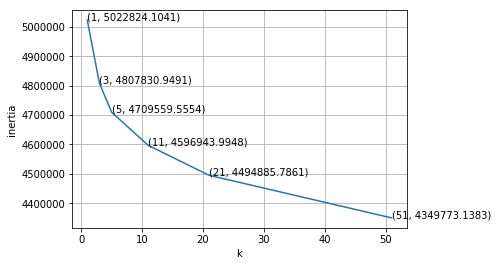

In [102]:
from sklearn.cluster import KMeans

count =  [1,3,5,11,21,51]
bow_inertia=[]
for k in count:
    print("for k =", k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(bag_counts)
    
    bow_inertia.append(kmeans.inertia_)
    





optimal_k = count[bow_inertia.index(min(bow_inertia))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(count, bow_inertia,label="inertia")



for xy in zip(count, np.round(bow_inertia,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('k')
plt.ylabel('inertia')

plt.show()


kmeans_bow = KMeans(n_clusters=optimal_k, random_state=0).fit(bag_counts)

# Number of Reviews in each cluster

In [106]:
n=kmeans_bow.labels_.shape[0]
cluster1_bow=[]
cluster2_bow=[]
cluster3_bow=[]
cluster4_bow=[]
cluster5_bow=[]
for index in range(n):
    if kmeans_bow.labels_[index]==0:
        cluster1_bow.append(preprocessed_reviews[index])
    elif kmeans_bow.labels_[index]==1:
        cluster2_bow.append(preprocessed_reviews[index])
    elif kmeans_bow.labels_[index]==2:
        cluster3_bow.append(preprocessed_reviews[index])
    elif kmeans_bow.labels_[index]==3:
        cluster4_bow.append(preprocessed_reviews[index])
        
    else: 
        cluster5_bow.append(preprocessed_reviews[index])
print("No. of reviews in Cluster-1 : ",len(cluster1_bow))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2_bow))
print("No. of reviews in Cluster-3 : ",len(cluster3_bow))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4_bow))
    

No. of reviews in Cluster-1 :  359

No. of reviews in Cluster-2 :  13
No. of reviews in Cluster-3 :  506

No. of reviews in Cluster-4 :  7388







### [5.1.2] Wordclouds for first four clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

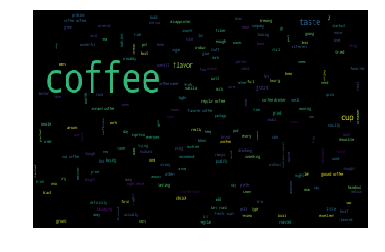

********* cluster 2 *********


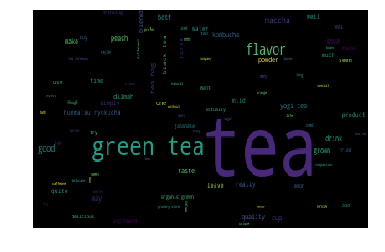

********* cluster 3 *********


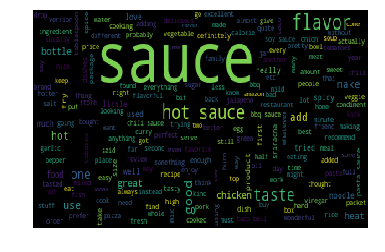

********* cluster 4 *********


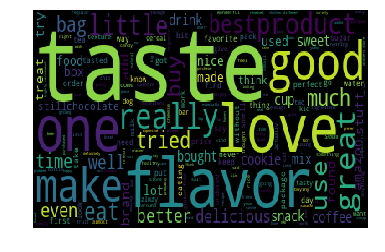

In [114]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import numpy as np
import matplotlib.pyplot as plt

string1 = " ".join(word for word in cluster1_bow)
string2= " ".join(word for word in cluster2_bow)
string3=" ".join(word for word in cluster3_bow)
string4=" ".join(word for word in cluster4_bow)


word_cloud = WordCloud(relative_scaling = 1.0).generate(string1)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 2 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string2)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()


print("********* cluster 3 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string3)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 4 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string4)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# OBSERVATIONS FROM THE WORD CLOUD

Kmeans BOW-


WordClouds 1 shows details about coffee and its flavours.


word cloud 2 show that the second cluster is about tea,green tea and their flavours.

WordCloud 3 -THe third cluster is about sauce and its flavours.


Word cloud 4-Most of the words in this word cloud show sentences with words good and the taste of the product .



# [5.1.5] Applying K-Means Clustering on TF-IDF,<font color='red'> SET 3</font>

for k = 1
for k = 3
for k = 5
for k = 11
for k = 21
for k = 51

The optimal alpha is . 51


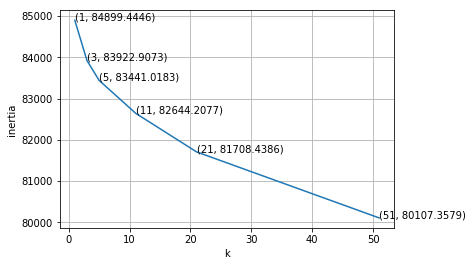

In [110]:
from sklearn.cluster import KMeans

count =  [1,3,5,11,21,51]
tfidf_inertia=[]
for k in count:
    print("for k =", k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(tfidf_text)
    
    tfidf_inertia.append(kmeans.inertia_)
    #cv=kmeans.predict(cvvalues)
    #cv_scores_cv.append(cv.inertia_)
optimal_k = count[tfidf_inertia.index(min(tfidf_inertia))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(count, tfidf_inertia,label="inertia")



for xy in zip(count, np.round(tfidf_inertia,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('k')
plt.ylabel('inertia')

plt.show()


kmeans_tfidf = KMeans(n_clusters=optimal_k, random_state=0).fit(tfidf_text)

# 



### [5.1.6] Wordclouds for first four clusters obtained after applying k-means on TFIDF<font color='red'> SET 1</font>

No. of reviews in Cluster-1 :  572

No. of reviews in Cluster-2 :  1223
No. of reviews in Cluster-3 :  2773

No. of reviews in Cluster-4 :  895


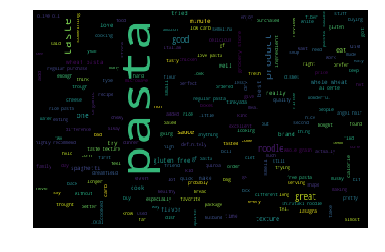

********* cluster 2 *********


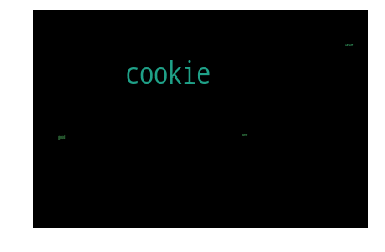

********* cluster 3 *********


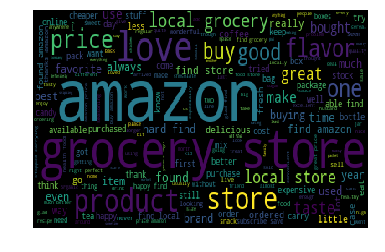

********* cluster 4 *********


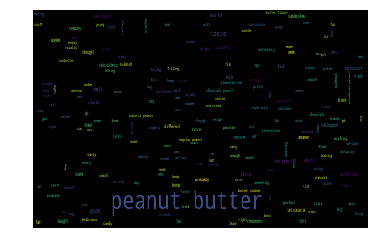

In [113]:
n=kmeans_tfidf.labels_.shape[0]
cluster1_tfidf=[]
cluster2_tfidf=[]
cluster3_tfidf=[]
cluster4_tfidf=[]
cluster5_tfidf=[]
for index in range(n):
    if kmeans_tfidf.labels_[index]==0:
        cluster1_tfidf.append(preprocessed_reviews[index])
    elif kmeans_tfidf.labels_[index]==1:
        cluster2_tfidf.append(preprocessed_reviews[index])
    elif kmeans_tfidf.labels_[index]==2:
        cluster3_tfidf.append(preprocessed_reviews[index])
    elif kmeans_tfidf.labels_[index]==3:
        cluster4_tfidf.append(preprocessed_reviews[index])
        
    else: 
        cluster5_tfidf.append(preprocessed_reviews[index])
print("No. of reviews in Cluster-1 : ",len(cluster1_tfidf))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2_tfidf))
print("No. of reviews in Cluster-3 : ",len(cluster3_tfidf))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4_tfidf))
    
    
string1 = " ".join(word for word in cluster1_tfidf)
string2= " ".join(word for word in cluster2_tfidf)
string3=" ".join(word for word in cluster3_tfidf)
string4=" ".join(word for word in cluster4_tfidf)


word_cloud = WordCloud(relative_scaling = 1.0).generate(string1)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 2 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string2)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()


print("********* cluster 3 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string3)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 4 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string4)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# OBSERVATIONS FROM THE WORD CLOUD

Kmeans TFIDF-

WordClouds 1 Most of the sentences about pasta and its flavours are shown on cluster1

Word Cloud 2 Most of the sentences in cluster 2 talk about cookie and its flavors

WordCloud 3 -Most of the words in this word cloud shows amazon grocery stores.


Word cloud 4-Most of the  sentences in cluster 4 talk about peanut butter.



### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

for k = 1
for k = 3
for k = 5
for k = 11
for k = 21
for k = 51

The optimal alpha is . 51


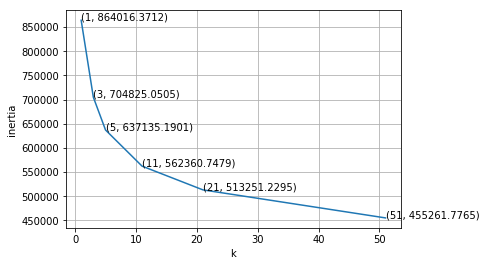

In [112]:
from sklearn.cluster import KMeans

count =  [1,3,5,11,21,51]
avg_word=[]
for k in count:
    print("for k =", k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(sent_vectors)
    
    avg_word.append(kmeans.inertia_)
    #cv=kmeans.predict(cvvalues)
    #cv_scores_cv.append(cv.inertia_)
optimal_k = count[avg_word.index(min(avg_word))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(count, avg_word,label="inertia")



for xy in zip(count, np.round(avg_word,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('k')
plt.ylabel('inertia')

plt.show()


kmeans_word = KMeans(n_clusters=optimal_k, random_state=0).fit(sent_vectors)

### [5.1.6] Wordclouds for first four clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

No. of reviews in Cluster-1 :  2258

No. of reviews in Cluster-2 :  1445
No. of reviews in Cluster-3 :  2189

No. of reviews in Cluster-4 :  1339

No. of reviews in Cluster-5 :  1887


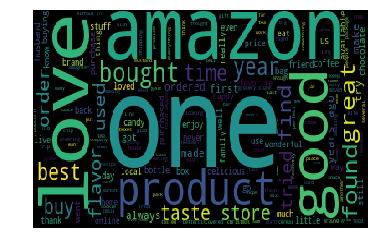

********* cluster 2 *********


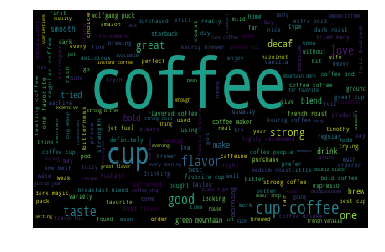

********* cluster 3 *********


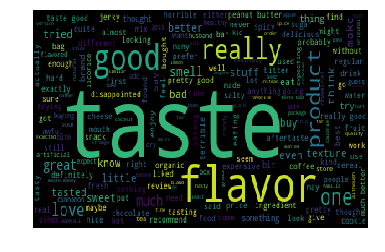

********* cluster 4 *********


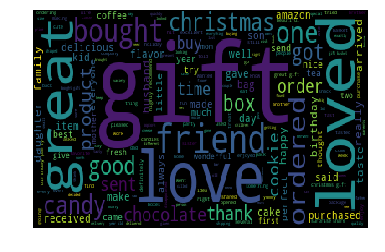

********* cluster 5 *********


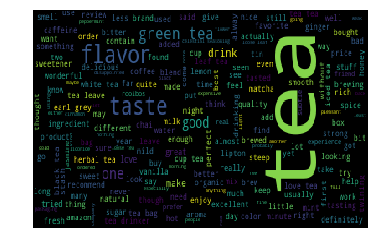

In [116]:
n=kmeans_word.labels_.shape[0]
cluster1_avg=[]
cluster2_avg=[]
cluster3_avg=[]
cluster4_avg=[]
cluster5_avg=[]
cluster6_avg=[]
for index in range(n):
    if kmeans_word.labels_[index]==0:
        cluster1_avg.append(preprocessed_reviews[index])
    elif kmeans_word.labels_[index]==1:
        cluster2_avg.append(preprocessed_reviews[index])
    elif kmeans_word.labels_[index]==2:
        cluster3_avg.append(preprocessed_reviews[index])
    elif kmeans_word.labels_[index]==3:
        cluster4_avg.append(preprocessed_reviews[index])
    elif kmeans_word.labels_[index]==4:
        cluster5_avg.append(preprocessed_reviews[index])
    
        
    else: 
        cluster6_avg.append(preprocessed_reviews[index])
print("No. of reviews in Cluster-1 : ",len(cluster1_avg))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2_avg))
print("No. of reviews in Cluster-3 : ",len(cluster3_avg))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4_avg))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5_avg))
    
    
    
string1 = " ".join(word for word in cluster1_avg)
string2= " ".join(word for word in cluster2_avg)
string3=" ".join(word for word in cluster3_avg)
string4=" ".join(word for word in cluster4_avg)
string5=" ".join(word for word in cluster5_avg)


word_cloud = WordCloud(relative_scaling = 1.0).generate(string1)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 2 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string2)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()


print("********* cluster 3 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string3)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 4 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string4)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 5 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string5)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# OBSERVATIONS FROM THE WORD CLOUD

Kmeans Word2Vec-

WordClouds 1 Most of the sentences show about positive words of the food items are shown on cluster1

Word Cloud 2 Most of the sentences in cluster 2 talk about Coffee and its falvours.

WordCloud 3 Most of the sentences in cluster 3 talk about taste of the food products and its flavours.


Word cloud 4-Most of the  sentences in cluster 4 talk christmas gifts and food items like chocolates,gifts and candies.

Word Cloud 5-Most of the sentences in cluster 5 talk about tea and its flavours.

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

for k = 1
for k = 3
for k = 5
for k = 11
for k = 21
for k = 51

The optimal alpha is . 51


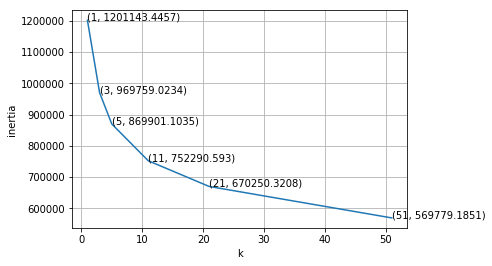

In [117]:
from sklearn.cluster import KMeans

count =  [1,3,5,11,21,51]
tfidf_word=[]
for k in count:
    print("for k =", k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(tfidf_sent_vectors)
    
    tfidf_word.append(kmeans.inertia_)
    #cv=kmeans.predict(cvvalues)
    #cv_scores_cv.append(cv.inertia_)
optimal_k = count[tfidf_word.index(min(tfidf_word))]
print('\nThe optimal alpha is .', optimal_k)
plt.plot(count, tfidf_word,label="inertia")



for xy in zip(count, np.round(tfidf_word,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('k')
plt.ylabel('inertia')

plt.show()


kmeans_word = KMeans(n_clusters=optimal_k, random_state=0).fit(tfidf_sent_vectors)

# [5.1.8] Wordclouds of first five clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

No. of reviews in Cluster-1 :  672

No. of reviews in Cluster-2 :  3280
No. of reviews in Cluster-3 :  3632

No. of reviews in Cluster-4 :  1958

No. of reviews in Cluster-5 :  1721


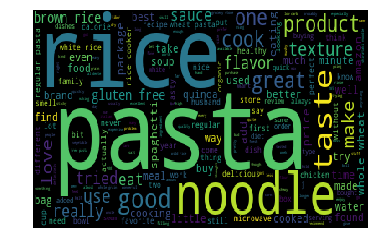

********* cluster 2 *********


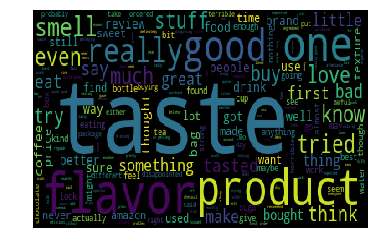

********* cluster 3 *********


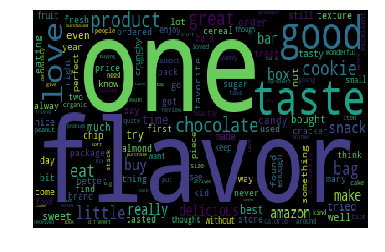

********* cluster 4 *********


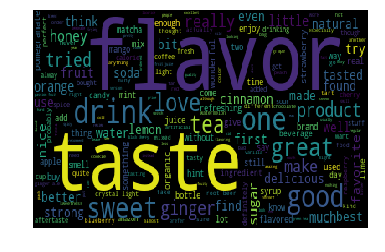

********* cluster 5 *********


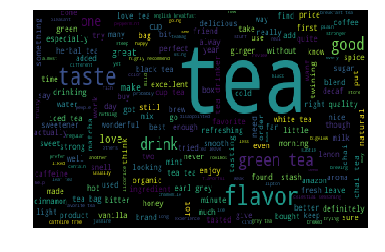

In [118]:
n=kmeans_word.labels_.shape[0]
cluster1_tfidf=[]
cluster2_tfidf=[]
cluster3_tfidf=[]
cluster4_tfidf=[]
cluster5_tfidf=[]
cluster6_tfidf=[]
for index in range(n):
    if kmeans_word.labels_[index]==0:
        cluster1_tfidf.append(preprocessed_reviews[index])
    elif kmeans_word.labels_[index]==1:
        cluster2_tfidf.append(preprocessed_reviews[index])
    elif kmeans_word.labels_[index]==2:
        cluster3_tfidf.append(preprocessed_reviews[index])
    elif kmeans_word.labels_[index]==3:
        cluster4_tfidf.append(preprocessed_reviews[index])
    elif kmeans_word.labels_[index]==4:
        cluster5_tfidf.append(preprocessed_reviews[index])
    
        
    else: 
        cluster6_tfidf.append(preprocessed_reviews[index])
print("No. of reviews in Cluster-1 : ",len(cluster1_tfidf))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2_tfidf))
print("No. of reviews in Cluster-3 : ",len(cluster3_tfidf))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4_tfidf))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5_tfidf))
    
    
    
string1 = " ".join(word for word in cluster1_tfidf)
string2= " ".join(word for word in cluster2_tfidf)
string3=" ".join(word for word in cluster3_tfidf)
string4=" ".join(word for word in cluster4_tfidf)
string5=" ".join(word for word in cluster5_tfidf)


word_cloud = WordCloud(relative_scaling = 1.0).generate(string1)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 2 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string2)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()


print("********* cluster 3 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string3)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 4 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string4)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 5 *********")



word_cloud = WordCloud(relative_scaling = 1.0).generate(string5)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# OBSERVATIONS FROM THE WORD CLOUD

Kmeans TFIDF Word2Vec-


WordClouds 1 Most of the sentences talk about items like rice ,pasta,noodles their taste and theri flavours.

Word Cloud 2  Most of the sentences in cluster 3 talk about taste of the food products and its flavours.




Word cloud 4-Most of the  sentences in cluster 4 talk about flavours of different items.

Word Cloud 5-Most of the sentences in cluster 5 talk about tea.

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

for k = 2
for k = 4
for k = 6
for k = 8

The optimal alpha is . 2


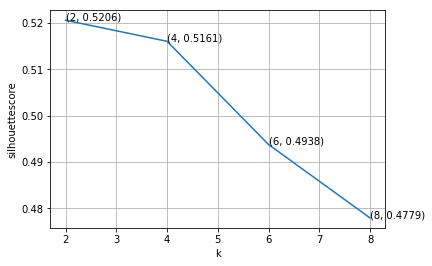

In [74]:
# Please write all the code with proper documentation

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import pairwise_distances
silhouette_score=[]
myList = list(range(1,10))
count = list(filter(lambda x: x % 2 == 0, myList))
for k in count:
    print("for k =", k)
    agg = AgglomerativeClustering(n_clusters=k).fit(sent_vectors_aandd)
    labels = agg.labels_
    score=metrics.silhouette_score(sent_vectors_aandd, labels, metric='euclidean')
    silhouette_score.append(score)
optimal_cluster = count[silhouette_score.index(max(silhouette_score))]
print('\nThe optimal alpha is .', optimal_cluster)
    
plt.plot(count, silhouette_score,label="silhouettescore")



for xy in zip(count, np.round(silhouette_score,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('k')
plt.ylabel('silhouettescore')

plt.show()   
    
    
agg = AgglomerativeClustering(n_clusters=optimal_cluster).fit(sent_vectors_aandd)
label=agg.labels_
label_list=label.tolist()
    


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [75]:
n=agg.labels_.shape[0]
cluster1=[]
cluster2=[]
for index in range(n):
    if agg.labels_[index]==0:
        cluster1.append(data_agg_check[index])
    else: 
        cluster2.append(data_agg_check[index])
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
    

No. of reviews in Cluster-1 :  780

No. of reviews in Cluster-2 :  1220


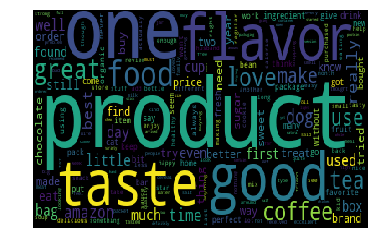

********* cluster 2 *********


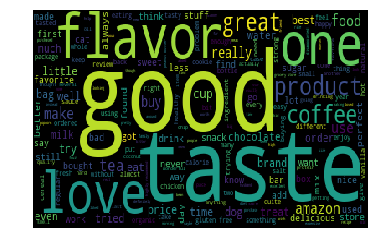

In [76]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import numpy as np
import matplotlib.pyplot as plt

string1 = " ".join(word for word in cluster1)
string2= " ".join(word for word in cluster2)


word_cloud = WordCloud(relative_scaling = 1.0).generate(string1)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 2 *********")
string2 = " ".join(word for word in cluster2)


word_cloud = WordCloud(relative_scaling = 1.0).generate(string2)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# OBSERVATIONS FROM THE WORD CLOUD

Cluster1 -Most of the sentences that talk about various tastes and flavours

 of good food.
 
 
Cluster2-Most of the sentences talk about positive review words of items.

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

for k = 2
for k = 4
for k = 6
for k = 8

The optimal alpha is . 2


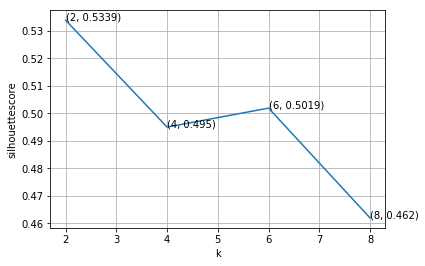

In [82]:
# Please write all the code with proper documentation

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import pairwise_distances
silhouette_score=[]
myList = list(range(1,10))
count = list(filter(lambda x: x % 2 == 0, myList))
for k in count:
    print("for k =", k)
    agg = AgglomerativeClustering(n_clusters=k).fit(tfidf_sent_vectors_aandd)
    labels = agg.labels_
    score=metrics.silhouette_score(tfidf_sent_vectors_aandd, labels, metric='euclidean')
    silhouette_score.append(score)
optimal_cluster = count[silhouette_score.index(max(silhouette_score))]
print('\nThe optimal alpha is .', optimal_cluster)
    
plt.plot(count, silhouette_score,label="silhouettescore")



for xy in zip(count, np.round(silhouette_score,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('k')
plt.ylabel('silhouettescore')

plt.show()   
    
    
agg = AgglomerativeClustering(n_clusters=optimal_cluster).fit(tfidf_sent_vectors_aandd)
label=agg.labels_
label_list=label.tolist()
    


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

In [83]:
n=agg.labels_.shape[0]
cluster1_tfidf=[]
cluster2_tfidf=[]
for index in range(n):
    if agg.labels_[index]==0:
        cluster1_tfidf.append(data_agg_check[index])
    else: 
        cluster2_tfidf.append(data_agg_check[index])
print("No. of reviews in Cluster-1 : ",len(cluster1_tfidf))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2_tfidf))
    

No. of reviews in Cluster-1 :  1302

No. of reviews in Cluster-2 :  698


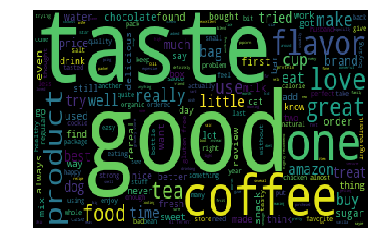

********* cluster 2 *********


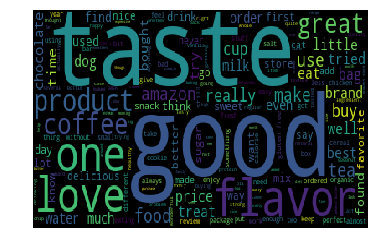

In [84]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import numpy as np
import matplotlib.pyplot as plt

string1 = " ".join(word for word in cluster1_tfidf)
string2= " ".join(word for word in cluster2_tfidf)


word_cloud = WordCloud(relative_scaling = 1.0).generate(string1)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 2 *********")
string2 = " ".join(word for word in cluster2)


word_cloud = WordCloud(relative_scaling = 1.0).generate(string2)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()

# OBSERVATIONS FROM THE WORD CLOUD

cluster 1- Most of the sentences are of postive reviews and many talk about tea , coffee and their flavors.


cluster 2-Most of the sentences are of postive reviews and many talk about flavor of the items.

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [85]:
from sklearn.cluster import DBSCAN

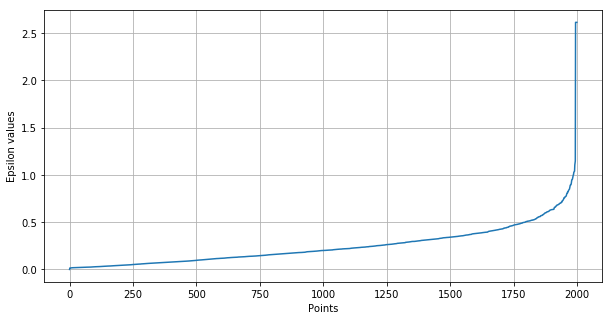

In [121]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure
min_points = 2*len(sent_vectors_aandd[0])
x=len(sent_vectors_aandd)
def nndistance(vectors, minpoints):
    ndistances = []
    for i in vectors:
        sq_dis = np.sum((vectors-i)**2,axis=1)
        ndistances.append(sq_dis[minpoints])
    return np.sqrt(np.array(ndistances))

distances = nndistance(sent_vectors_aandd,min_points)
sorted_distance = np.sort(distances)      ## sorting the values of distances
points = [i for i in range(x)]



    
plt.figure(figsize=(10,5))
plt.plot(points, sorted_distance)
plt.grid()

plt.xlabel('Points')
plt.ylabel('Epsilon values')
plt.show()





    


From above graph we take eps value as 0.6

In [90]:
# Please write all the code with proper documentation 
#eps is taken as 0.6 from above graph
from wordcloud import WordCloud
from matplotlib.pyplot import figure
min_points = 2*len(sent_vectors_aandd[0])

k=0.6
indices1 = []
text1 = []
sentence1 = ''
indices2 = []
text2 = []
sentence2 = ''
dbscan = DBSCAN(eps=k, min_samples=min_points).fit(sent_vectors_aandd)

dbscan_values = dbscan.fit_predict(sent_vectors_aandd) ##predicting the cluster
n_clusters = len(set(dbscan.labels_))

print(" number of clusters is :",n_clusters)





 number of clusters is : 2


No. of reviews in Cluster-1 :  1994

No. of reviews in Cluster-2 :  6


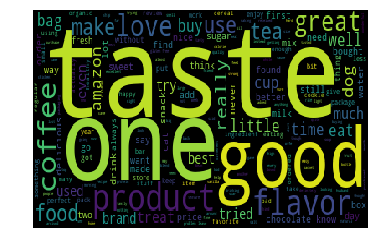

********* cluster 2 *********


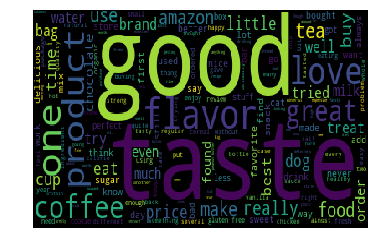

In [98]:
n=dbscan.labels_.shape[0]
cluster1_dbscan=[]
cluster2_dbscan=[]
for index in range(n):
    if dbscan.labels_[index]==0:
        cluster1_dbscan.append(data_agg_check[index])
    else: 
        cluster2_dbscan.append(data_agg_check[index])
print("No. of reviews in Cluster-1 : ",len(cluster1_dbscan))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2_dbscan))


string1 = " ".join(word for word in cluster1_dbscan)
string2= " ".join(word for word in cluster2_dbscan)


word_cloud1 = WordCloud(relative_scaling = 1.0).generate(string1)
plt.imshow(word_cloud1,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 2 *********")
string2 = " ".join(word for word in cluster2)


word_cloud = WordCloud(relative_scaling = 1.0).generate(string2)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()
    

# OBSERVATIONS FROM THE WORD CLOUD

cluster1- Most of the reviews are positive and talk about various flavors ,some reviews talk about coffee and its tastes.

cluster 2- Most of the sentences are of postive reviews and many talk about flavor of the items.

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

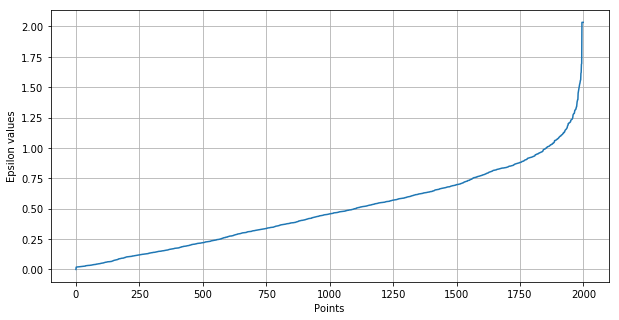

In [95]:
from wordcloud import WordCloud
from matplotlib.pyplot import figure
min_points = 2*len(tfidf_sent_vectors_aandd[0])
x=len(tfidf_sent_vectors_aandd)
def nndistance(vectors, minpoints):
    ndistances = []
    for i in vectors:
        sq_dis = np.sum((vectors-i)**2,axis=1)
        ndistances.append(sq_dis[minpoints])
    return np.sqrt(np.array(ndistances))

distances = nndistance(tfidf_sent_vectors_aandd,min_points)
sorted_distance = np.sort(distances)
points = [i for i in range(x)]



    
plt.figure(figsize=(10,5))
plt.plot(points, sorted_distance)
plt.grid()

plt.xlabel('Points')
plt.ylabel('Epsilon values')
plt.show()

From above graph we take eps value as 0.7

In [96]:
# Please write all the code with proper documentation
# eps is taken as 0.8 from above graph
from wordcloud import WordCloud
from matplotlib.pyplot import figure
min_points = 2*len(tfidf_sent_vectors_aandd[0])
k=1.0
indices1 = []
text1 = []
sentence1 = ''
dbscan = DBSCAN(eps=k, min_samples=min_points).fit(tfidf_sent_vectors_aandd)

dbscan_values = dbscan.fit_predict(tfidf_sent_vectors_aandd) ##predicting the cluster
n_clusters = len(set(dbscan.labels_))

print(" number of clusters is :",n_clusters)




 number of clusters is : 2


No. of reviews in Cluster-1 :  1994

No. of reviews in Cluster-2 :  6


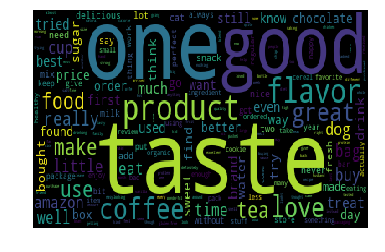

********* cluster 2 *********


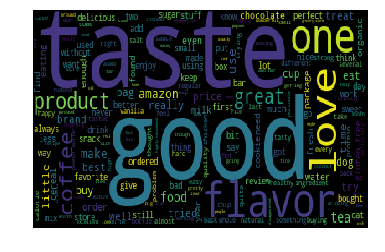

In [99]:
n=dbscan.labels_.shape[0]
cluster1_dbscan_tfidf=[]
cluster2_dbscan_tfidf=[]
for index in range(n):
    if dbscan.labels_[index]==0:
        cluster1_dbscan_tfidf.append(data_agg_check[index])
    else: 
        cluster2_dbscan_tfidf.append(data_agg_check[index])
print("No. of reviews in Cluster-1 : ",len(cluster1_dbscan_tfidf))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2_dbscan_tfidf))


string1 = " ".join(word for word in cluster1_dbscan_tfidf)
string2= " ".join(word for word in cluster2_dbscan_tfidf)


word_cloud1 = WordCloud(relative_scaling = 1.0).generate(string1)
plt.imshow(word_cloud1,aspect='auto')
plt.axis('off')
plt.show()

print("********* cluster 2 *********")
string2 = " ".join(word for word in cluster2)


word_cloud = WordCloud(relative_scaling = 1.0).generate(string2)
plt.imshow(word_cloud,aspect='auto')
plt.axis('off')
plt.show()
    

# OBSERVATIONS FROM THE WORD CLOUD

cluster 1-Most of the senteces are about taste and flavor of items and many are postive reviews.

cluster2-Most of the sentences are of postive reviews and many talk about flavor of the items.

# [6] Conclusions

In [120]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "number of clusters"]
x.add_row(["BOW", "kmeans clustering",51 ])
x.add_row(["TF-IDF", "kmeans clustering",51 ])
x.add_row(["AVG-word 2vec", "kmeans clustering",51 ])

x.add_row([" TFIDF W2v", "kmeans clustering",51])

x.add_row(["AVG-word 2vec", "agglomerative clustering",2 ])
x.add_row(["TFIDF W2v", "agglomerative clustering",2 ])
print(x)
 
y = PrettyTable()
y.field_names = ["Vectorizer", "Model","eps","number of clusters" ]
y.add_row(["AVG-word 2vec", " DBScan",0.6,2])


y.add_row([" TFIDF W2v", "DBScan",0.7,2])
print(y)

+---------------+--------------------------+--------------------+
|   Vectorizer  |          Model           | number of clusters |
+---------------+--------------------------+--------------------+
|      BOW      |    kmeans clustering     |         51         |
|     TF-IDF    |    kmeans clustering     |         51         |
| AVG-word 2vec |    kmeans clustering     |         51         |
|    TFIDF W2v  |    kmeans clustering     |         51         |
| AVG-word 2vec | agglomerative clustering |         2          |
|   TFIDF W2v   | agglomerative clustering |         2          |
+---------------+--------------------------+--------------------+
+---------------+---------+-----+--------------------+
|   Vectorizer  |  Model  | eps | number of clusters |
+---------------+---------+-----+--------------------+
| AVG-word 2vec |  DBScan | 0.6 |         2          |
|    TFIDF W2v  |  DBScan | 0.7 |         2          |
+---------------+---------+-----+--------------------+
